<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230529_DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data drift에 내성이 있는 학습 방법

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [4]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

In [5]:

def test_model(model_,model2_, tX, ty, s1):
    model_.eval()
    model2_.eval()

    ax = model2_(tX[:,0:5],tX[:,5].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    
    f1 = f1_score(ty.cpu().data.numpy(),y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4].cpu().data.numpy(),columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [6]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).
    
    This class is for defining the structure of FR-Train generator (classifier). 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted label (y_hat) for the given input data.
        """
        
        output = self.model(input_data)
        return output


In [7]:

def test_all_data(generator,adapter,XT,yT):

    #XT = X[train_size:][['x0','x1','x2','x3','z0','b']]
    #yT = y[train_size:]

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    print('XT.shape',XT.shape)
    bucket_size_array=[200]
    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
            xs = adapter(tmp_x[:,0:5],tmp_x[:,5].reshape(-1,1)/avaible_range)
            predicted_y = generator(xs)
            predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

In [8]:
#  I(Z,B) > 0의 관계에 대해 z0를 전처리
class Sensitivity_Adapter(nn.Module):
   
    def __init__(self,input_dim):
        """Initializes DiscriminatorF with torch components."""
        
        super(Sensitivity_Adapter, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        #self.fc3 = nn.ModuleList()
        
        for i in range(self.input_dim): 
            self.fc1.append(nn.Linear(2, 50))
            self.fc2.append(nn.Linear(50, 1))
            #self.fc3.append(nn.Linear(5, 1))

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1)))
            #h1 = F.relu(self.fc2[i](h0))
            #h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = self.fc2[i](h0)
            h2 = self.fc2[i](h0)
            pxy.append(h2)
            
        return torch.cat(pxy, dim=1)
     

In [9]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):
    seed_everything()
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    s1_train = train_tensors.s1_train.to(device)
    
    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    s1_test = test_tensors.s1_test.to(device)
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator().to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    #mine = Net()
    #optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 1000

    for epoch in range(n_epochs):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------
        xs = adapter(XS_train[:,0:5],XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
        a_loss = torch.sum(mse_loss(xs, XS_train[:,0:5]))

        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        #loss.backward()
        mi_losses.append(a_loss)
        #optimizer_D_F.step()

        loss = (1-lambda_f) * g_loss +  lambda_f * a_loss * alpha #* 0.05

        loss.backward()
        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()            

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator,adapter

# 준비
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

In [10]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [11]:
seed_everything()

y= (np.random.normal(0.5,0.5,100) > 0.5).astype(int)
sum(y)

40

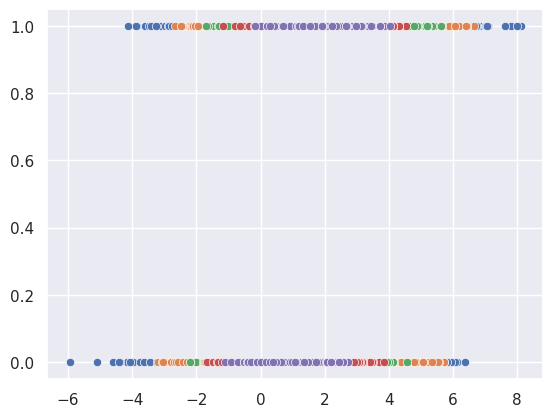

In [12]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

<Axes: >

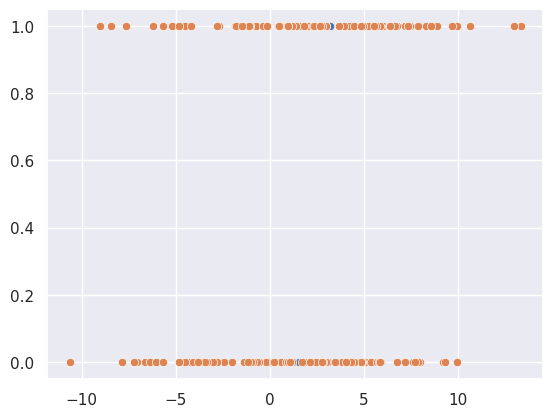

In [13]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)    
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
sns.scatterplot(x=x[0:200,4],y=y[0:200])
sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

## KS-test 통계량의 측정

In [14]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]   
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)
    
    #if ks_stat == minS:
    #    ks_stat = -ks_stat
    
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [15]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [16]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
x1    0.079411
x0    0.050887
z0    0.027068
Name: MI Scores, dtype: float64


Bucket size 10


100%|██████████| 10/10 [00:01<00:00,  7.60it/s]


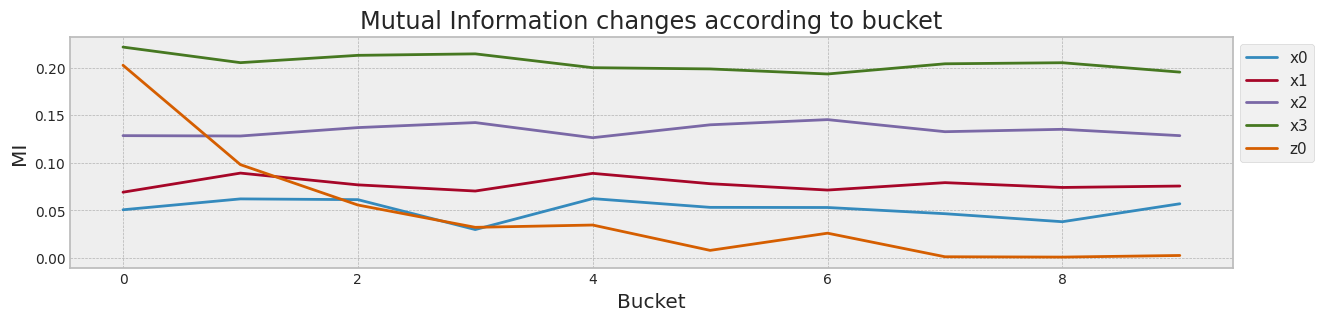

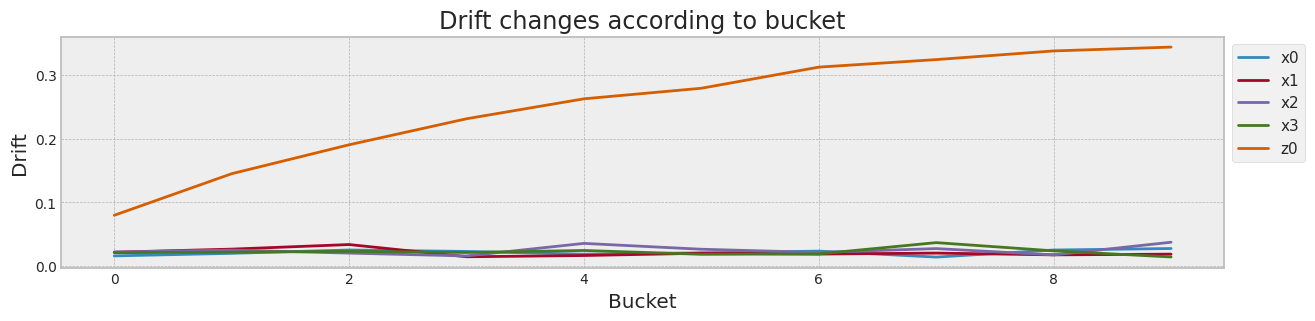

In [17]:
from tqdm import tqdm

bucket_size_array=[10]#[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((x.shape[0]-2000)/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*step_size:bk*step_size+step_size], y[bk*step_size:bk*step_size+step_size], discrete_features="auto")
        ks = __ks_drift(X[0:1800].values,X[bk*step_size+2000:bk*step_size+step_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col]) 
            DRF[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    df_mis.plot(figsize=(15,3),title='Mutual Information changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    df_drf.plot(figsize=(15,3),title='Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

## 학습 및 전체 예측

+ 2000개를 학습하고, 이후 38000개를 추정한다.

cuda:0


100%|██████████| 1000/1000 [00:25<00:00, 39.27it/s]


MSE: 0.26
RMSE: 0.51


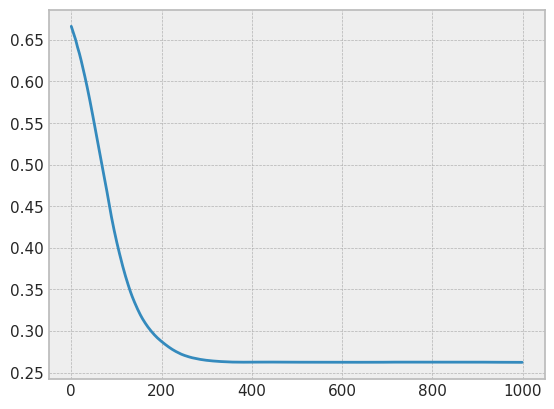

In [18]:
import copy
import torch.optim as optim
 
seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [19]:
result_table3 = {}
result_table3['lambda']=[]
result_table3['test_f1']=[]
result_table3['init_f1']=[]
result_table3['mean_f1']=[]
result_table3['last_f1']=[]
result_table3['MI(y^,z)']=[]

In [20]:

from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

feature 5, test_f1 0.8685714285714285


100%|██████████| 189/189 [00:00<00:00, 547.51it/s]


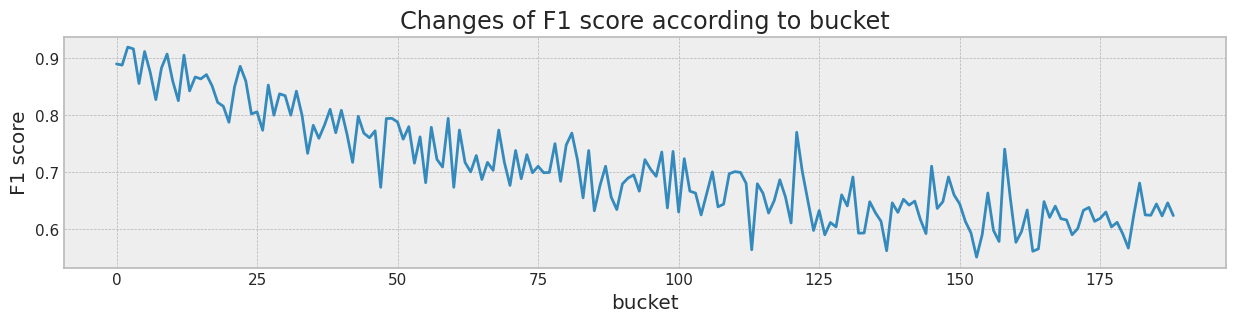

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.002514

In [21]:

XT = X[2000:][['x0','x1','x2','x3','z0']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.ylabel('F1 score')
    plt.xlabel('bucket')
    plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3['lambda'].append('Case #1 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

## 내성 학습의 적용

In [22]:

# bucket 하나의 크기는 100
# 2000개의 학습데이터에는 20개의 bucket이 있음.
# 학습데이터 100개당 +1의 bucket count를 증가 시킴
X['b'] = [int(b) for b in X.index.values/100]
X

x0        x1        x2        x3        z0    b
0      2.231833  0.663053  2.160447  1.180836  1.125117    0
1      1.326272  2.285045  2.362769  2.638806  2.171340    0
2      1.845348  3.743190  3.310210  1.772473  2.576518    0
3      2.974414 -0.229197  1.024580  1.387895  0.873782    0
4      2.854022  3.102544  1.610779  1.774781  2.490660    0
...         ...       ...       ...       ...       ...  ...
39995  0.085122 -0.571732  1.527233  1.867146 -1.177338  399
39996  1.069521 -0.221247  1.324087  1.798258  4.045168  399
39997  0.429295  2.593988  2.329410  1.859496  1.785665  399
39998  1.611266 -0.588687 -0.591898  2.126287  9.291351  399
39999  3.872531  0.931353  3.595759  1.948642  7.307901  399

[40000 rows x 6 columns]

lambda_f2 1.2
cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 19.316162] [G loss: 0.511208]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 105.180084] [G loss: 0.266944]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 188.331757] [G loss: 0.227124]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 210.090500] [G loss: 0.224848]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 220.921432] [G loss: 0.223697]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 229.876511] [G loss: 0.222694]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 237.072784] [G loss: 0.221774]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 244.026840] [G loss: 0.220871]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 251.326172] [G loss: 0.220045]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 257.993988] [G loss: 0.219292]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 261.778290] [G loss: 0.218563]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 264.07

100%|██████████| 189/189 [00:00<00:00, 358.00it/s]


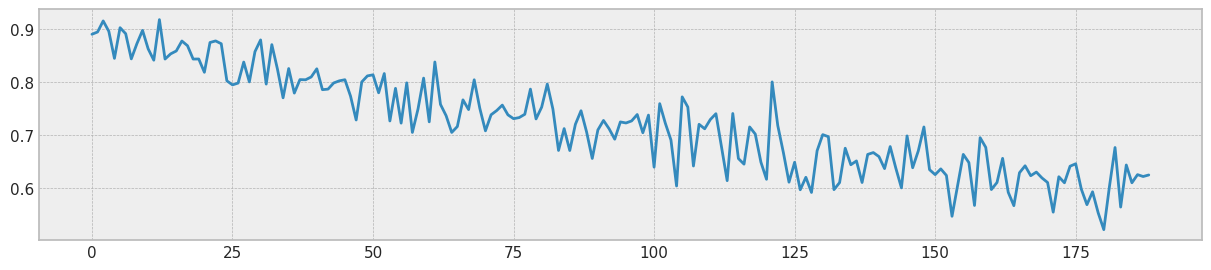

Mean F1 for all data: 0.721176812135385
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 0.020037] [G loss: 0.623222]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 0.078506] [G loss: 0.569837]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 0.167775] [G loss: 0.496585]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 0.265451] [G loss: 0.416552]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 0.298769] [G loss: 0.355171]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 0.284817] [G loss: 0.316309]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 0.253056] [G loss: 0.292837]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 0.220653] [G loss: 0.277176]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 0.190217] [G loss: 0.266409]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 0.167690] [G loss: 0.257279]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 0.148677] [G loss: 0.249762]
[Lambda: 0.100000] [Epoch 2400/4000] [mi loss: 0

100%|██████████| 189/189 [00:00<00:00, 352.81it/s]


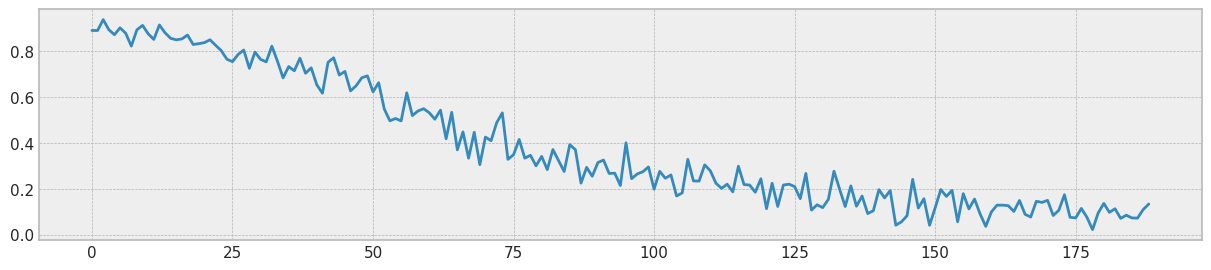

Mean F1 for all data: 0.38773448433790614
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 0.007139] [G loss: 0.627994]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 0.018357] [G loss: 0.583075]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 0.039199] [G loss: 0.526471]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 0.066431] [G loss: 0.461640]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 0.086831] [G loss: 0.401224]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 0.093520] [G loss: 0.353786]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 0.091924] [G loss: 0.320146]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 0.084111] [G loss: 0.297693]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 0.075252] [G loss: 0.281987]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 0.066586] [G loss: 0.270301]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 0.058860] [G loss: 0.260837]
[Lambda: 0.200000] [Epoch 2400/4000] [mi loss:

100%|██████████| 189/189 [00:00<00:00, 330.40it/s]


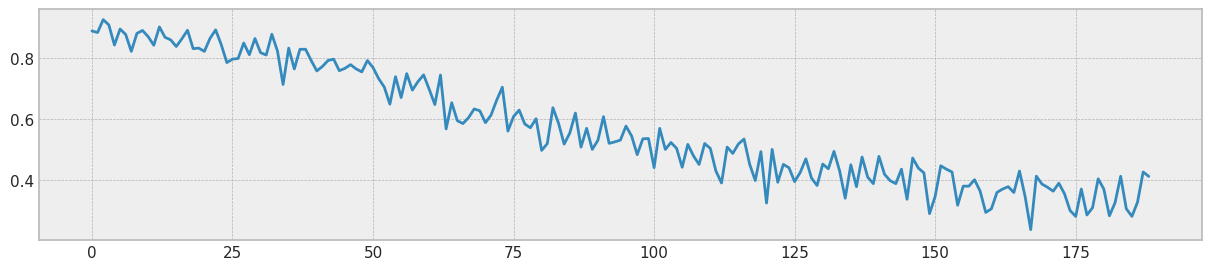

Mean F1 for all data: 0.5728063349608085
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 0.005376] [G loss: 0.629871]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 0.006886] [G loss: 0.588285]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 0.014519] [G loss: 0.538230]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 0.025471] [G loss: 0.480858]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 0.035334] [G loss: 0.424462]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 0.041426] [G loss: 0.376283]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 0.043034] [G loss: 0.339537]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 0.040916] [G loss: 0.312969]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 0.037128] [G loss: 0.293951]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 0.032860] [G loss: 0.279442]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 0.028636] [G loss: 0.267709]
[Lambda: 0.300000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 346.18it/s]


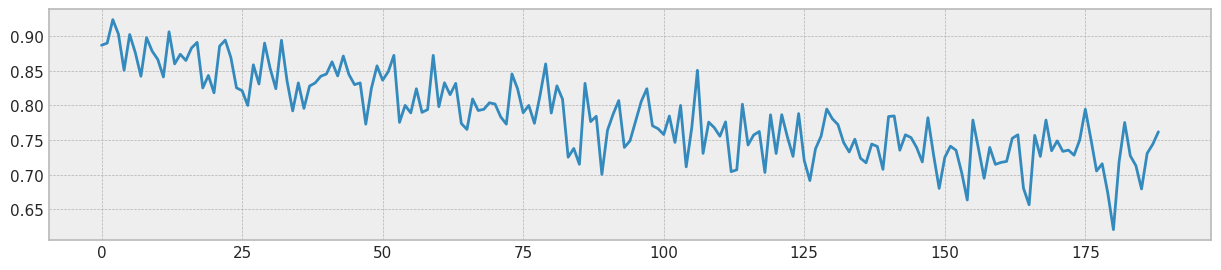

Mean F1 for all data: 0.7850010068760686
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.005101] [G loss: 0.630879]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.003148] [G loss: 0.591079]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 0.006397] [G loss: 0.544595]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 0.011234] [G loss: 0.491947]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 0.016194] [G loss: 0.438926]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.019932] [G loss: 0.391833]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 0.021470] [G loss: 0.354412]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.021262] [G loss: 0.325588]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 0.019570] [G loss: 0.304038]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 0.017511] [G loss: 0.287310]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 0.014857] [G loss: 0.273877]
[Lambda: 0.400000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 351.26it/s]


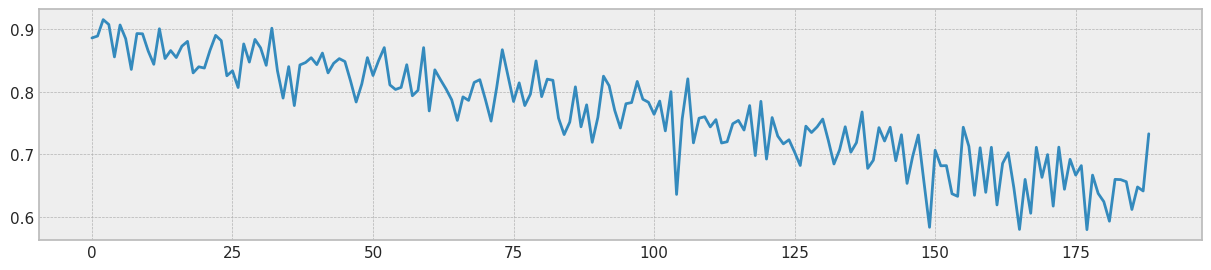

Mean F1 for all data: 0.7659473098764698
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.005159] [G loss: 0.631501]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.001599] [G loss: 0.592844]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 0.003039] [G loss: 0.548592]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 0.005177] [G loss: 0.499179]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 0.007710] [G loss: 0.448796]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 0.009757] [G loss: 0.403218]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 0.010920] [G loss: 0.365708]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 0.010945] [G loss: 0.336137]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 0.010325] [G loss: 0.312799]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 0.009238] [G loss: 0.294069]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 0.007964] [G loss: 0.278928]
[Lambda: 0.500000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 354.83it/s]


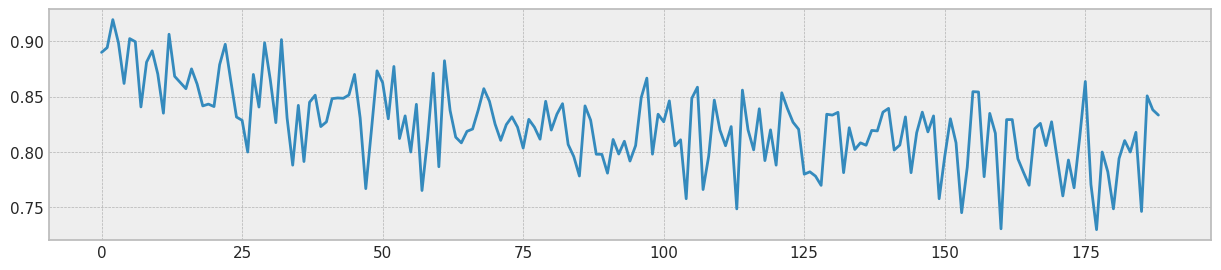

Mean F1 for all data: 0.8244244113177561
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 0.005296] [G loss: 0.631926]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 0.000920] [G loss: 0.594047]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 0.001478] [G loss: 0.551396]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 0.002448] [G loss: 0.504040]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 0.003603] [G loss: 0.455949]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 0.004680] [G loss: 0.411699]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 0.005354] [G loss: 0.374579]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 0.005465] [G loss: 0.344564]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 0.005190] [G loss: 0.320457]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 0.004633] [G loss: 0.300408]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 0.004001] [G loss: 0.284052]
[Lambda: 0.600000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 343.88it/s]


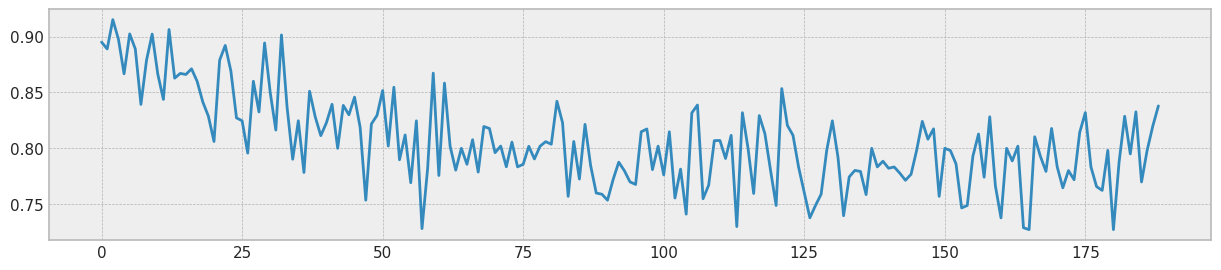

Mean F1 for all data: 0.8060833514922492
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 0.005442] [G loss: 0.632233]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 0.000630] [G loss: 0.594915]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 0.000662] [G loss: 0.553504]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 0.001035] [G loss: 0.507932]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 0.001551] [G loss: 0.461480]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 0.002032] [G loss: 0.418524]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 0.002417] [G loss: 0.381711]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 0.002499] [G loss: 0.351338]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 0.002388] [G loss: 0.326485]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 0.002161] [G loss: 0.305532]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 0.001879] [G loss: 0.288337]
[Lambda: 0.700000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 348.04it/s]


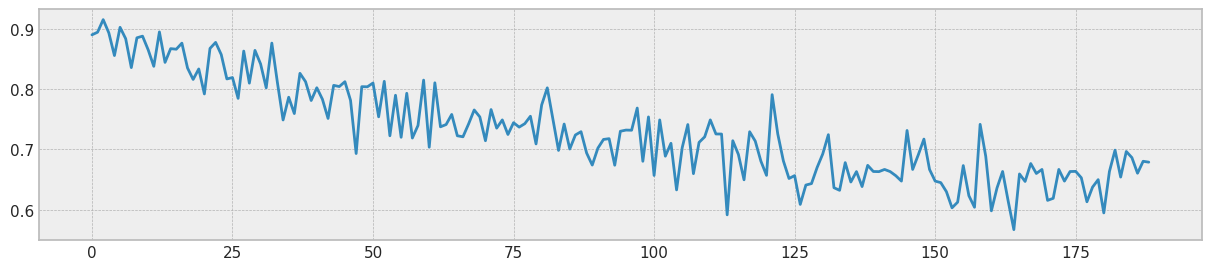

Mean F1 for all data: 0.730102436404008
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 0.005581] [G loss: 0.632467]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 0.000497] [G loss: 0.595641]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 0.000316] [G loss: 0.555041]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 0.000401] [G loss: 0.510713]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 0.000560] [G loss: 0.465739]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 0.000725] [G loss: 0.424046]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 0.000863] [G loss: 0.387982]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 0.000912] [G loss: 0.357326]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 0.000899] [G loss: 0.331731]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 0.000830] [G loss: 0.309941]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 0.000723] [G loss: 0.292065]
[Lambda: 0.800000] [Epoch 2400/4000] [mi loss: 0

100%|██████████| 189/189 [00:00<00:00, 348.41it/s]


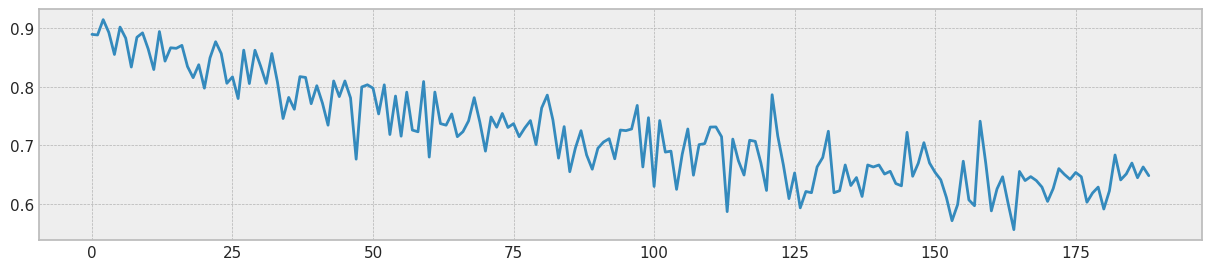

Mean F1 for all data: 0.7209201312161698
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 0.005705] [G loss: 0.632652]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 0.000453] [G loss: 0.596164]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 0.000182] [G loss: 0.556232]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 0.000127] [G loss: 0.512988]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 0.000144] [G loss: 0.469201]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 0.000171] [G loss: 0.428535]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 0.000195] [G loss: 0.393073]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 0.000204] [G loss: 0.362482]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 0.000197] [G loss: 0.336422]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 0.000184] [G loss: 0.314011]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 0.000163] [G loss: 0.295423]
[Lambda: 0.900000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 343.37it/s]


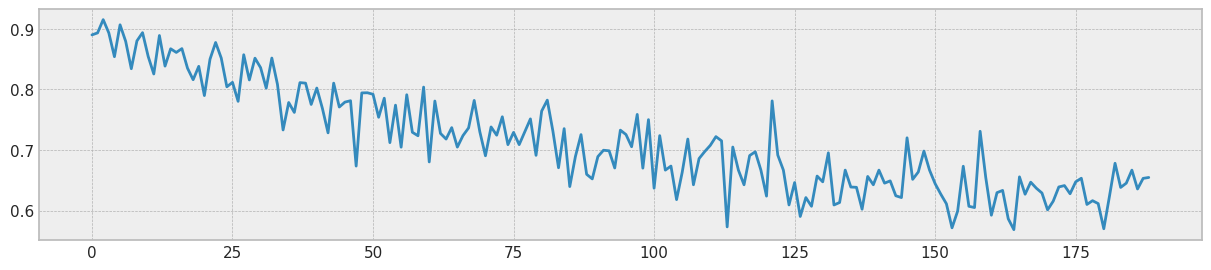

Mean F1 for all data: 0.714946437788246


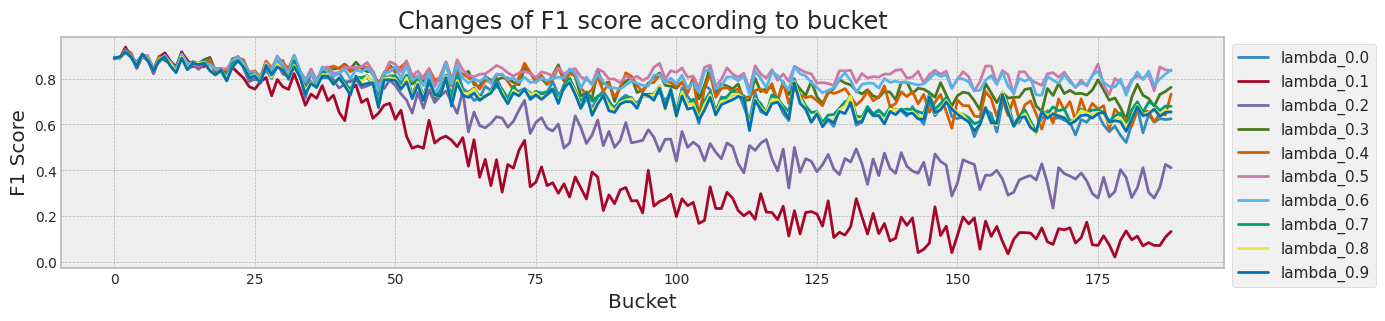

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.002514
0                0.0  0.898876  0.889908  0.721177  0.624390  0.265435
1                0.1  0.870056  0.889908  0.387734  0.133333  0.229369
2                0.2  0.858757  0.890909  0.572806  0.410959  0.228114
3                0.3  0.865169  0.886878  0.785001  0.761905  0.250609
4                0.4  0.870056  0.885845  0.765947  0.732673  0.266231
5                0.5  0.875000  0.889908  0.824424  0.833333  0.261667
6                0.6  0.881356  0.894977  0.806083  0.837945  0.259820
7                0.7  0.875000  0.889908  0.730102  0.678733  0.261667
8                0.8  0.875000  0.889908  0.720920  0.648402  0.261667
9                0.9  0.875000  0.889908  0.714946  0.654545  0.261667

In [23]:
avaible_range = 400
seed = 1
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
lambda_f_set2 = [1.2] 
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2
    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter,X[2000:][['x0','x1','x2','x3','z0','b']],y[2000:])

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3),title='Changes of F1 score according to bucket',ylabel='F1 Score',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    result4_df = pd.DataFrame(result_table2)

    #print(lambda_f2,result4_df)

pd.concat([pd.DataFrame(result_table3),result4_df])

## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

In [24]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [25]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [26]:
x1.shape

(40000, 5)

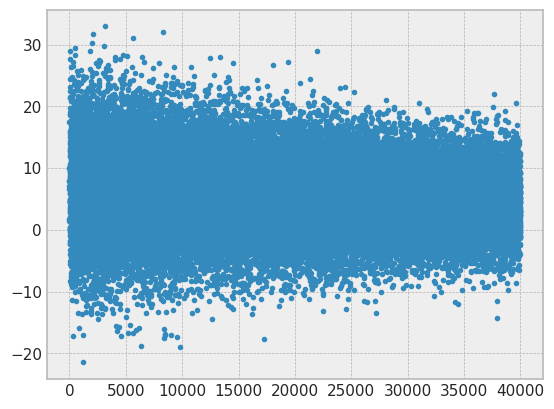

In [27]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4] 
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)
 
plt.plot(y1_array,'.')

In [28]:
y1 = [1 if y_ > 5 else 0 for y_ in y1_array]

In [29]:
sum(y1)

21325

In [30]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)
mi_scores = make_mi_scores(X1, y1, discrete_features="auto")
print(mi_scores)

x0    0.227465
z0    0.088169
x1    0.018550
x3    0.008429
x2    0.006772
Name: MI Scores, dtype: float64


Bucket size 50


100%|██████████| 50/50 [00:01<00:00, 45.29it/s]


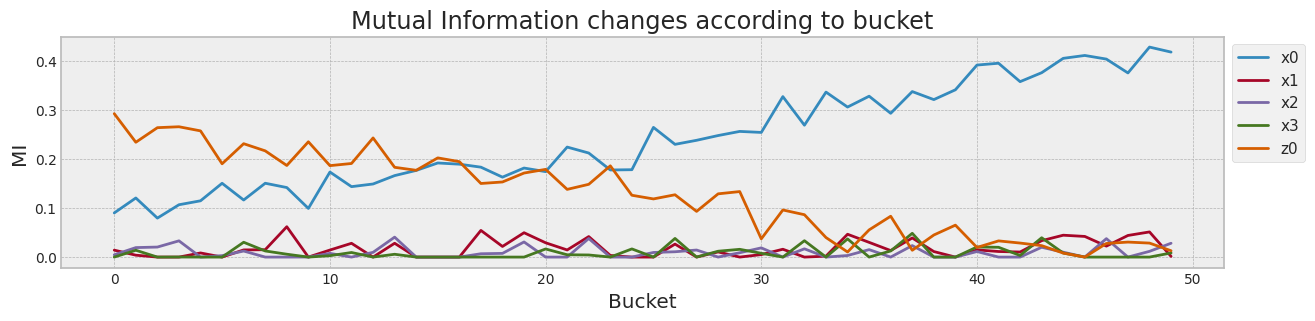

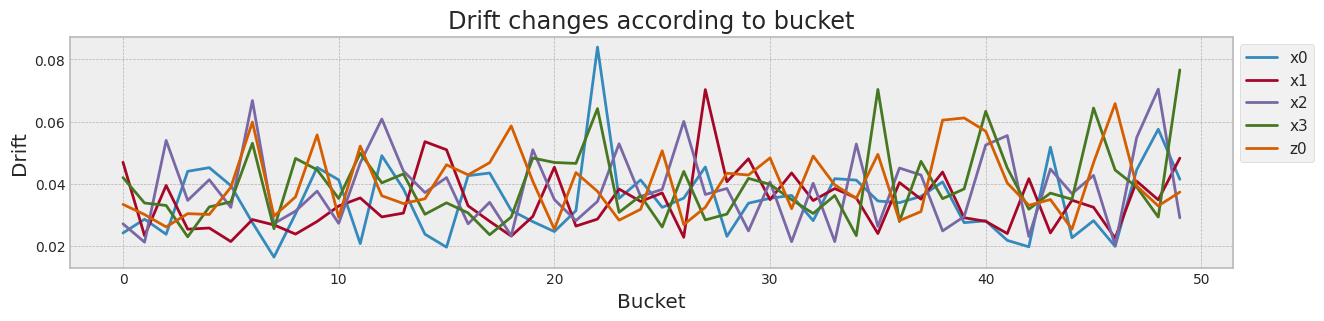

In [31]:
from tqdm import tqdm

bucket_size_array=[50]#[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((x.shape[0]-2000)/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X1[bk*step_size:bk*step_size+step_size], y1[bk*step_size:bk*step_size+step_size], discrete_features="auto")
        ks = __ks_drift(X1[0:1800].values,X1[bk*step_size+2000:bk*step_size+step_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col]) 
            DRF[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    df_mis.plot(figsize=(15,3),title='Mutual Information changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    df_drf.plot(figsize=(15,3),title='Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

## 학습 및 전체 예측

cuda:0


100%|██████████| 1000/1000 [00:24<00:00, 40.36it/s]


MSE: 0.04
RMSE: 0.19


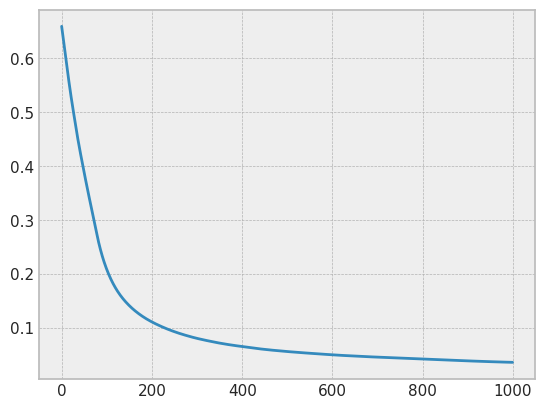

In [32]:
import copy
import torch.optim as optim
 
seed_everything()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y1[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y1[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

100%|██████████| 189/189 [00:00<00:00, 519.08it/s]


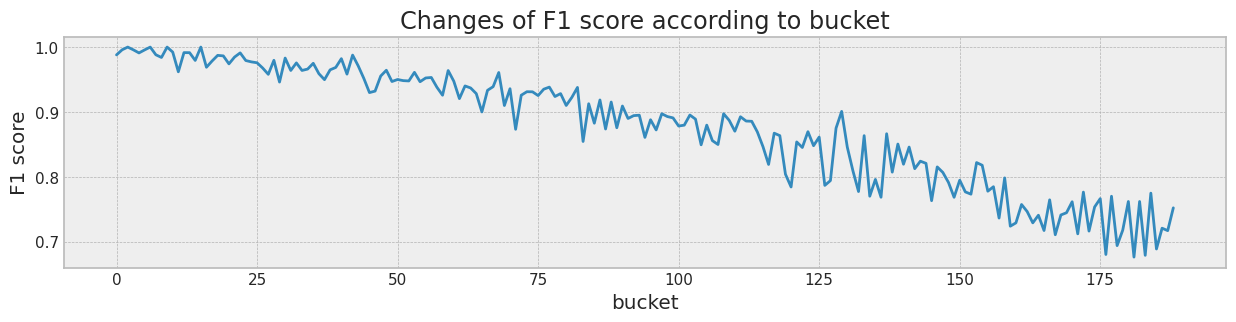

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.002514
1  Case #2 Feature 5  0.875000  0.987952  0.877103  0.752137  0.012903

In [33]:
XT = X1[2000:][['x0','x1','x2','x3','z0']]
yT = y1[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.ylabel('F1 score')
    plt.xlabel('bucket')
    plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3['lambda'].append('Case #2 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

In [34]:
X1['b'] = [int(b) for b in X1.index.values]
X1

x0        x1        x2        x3        z0      b
0      1.877314  1.185467 -0.002710  1.124792 -1.925585      0
1      2.846794  0.461018  1.213784  1.282154  3.281450      1
2      2.232850  0.876278  2.307393  2.019052  0.187403      2
3     -0.198843  2.579531  0.078102  1.019118  2.385340      3
4      1.618080  1.683218  1.826908  0.697273  0.195648      4
...         ...       ...       ...       ...       ...    ...
39995 -0.321489  0.268097 -0.178799  1.410070  4.096949  39995
39996 -0.037401  1.055617  0.084065  1.252068  3.850920  39996
39997  2.262545 -0.256564  1.445491  1.256208  0.498200  39997
39998  0.823467  1.489013 -0.191516 -0.238143  5.022454  39998
39999  2.024101  2.498025  0.198514  2.241146  0.816579  39999

[40000 rows x 6 columns]

cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 44.337929] [G loss: 0.479356]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 258.603058] [G loss: 0.167605]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 517.607544] [G loss: 0.078098]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 741.547424] [G loss: 0.051432]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 960.810425] [G loss: 0.037684]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 1181.940186] [G loss: 0.029118]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 1411.487183] [G loss: 0.022937]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 1654.074341] [G loss: 0.018343]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 1889.434204] [G loss: 0.015104]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 2127.275635] [G loss: 0.012432]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 2377.471191] [G loss: 0.010282]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 2642.408203] [

100%|██████████| 189/189 [00:00<00:00, 337.79it/s]


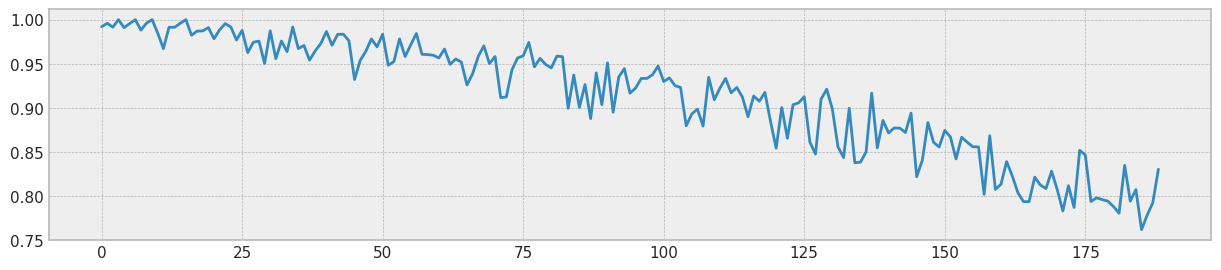

Mean F1 for all data: 0.9129560221808936
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 0.065951] [G loss: 0.575243]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 0.078144] [G loss: 0.493714]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 0.099995] [G loss: 0.420184]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 0.136796] [G loss: 0.340409]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 0.146494] [G loss: 0.270942]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 0.138476] [G loss: 0.221807]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 0.127138] [G loss: 0.185755]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 0.116526] [G loss: 0.158431]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 0.107120] [G loss: 0.137230]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 0.099970] [G loss: 0.120165]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 0.094113] [G loss: 0.106181]
[Lambda: 0.100000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 342.58it/s]


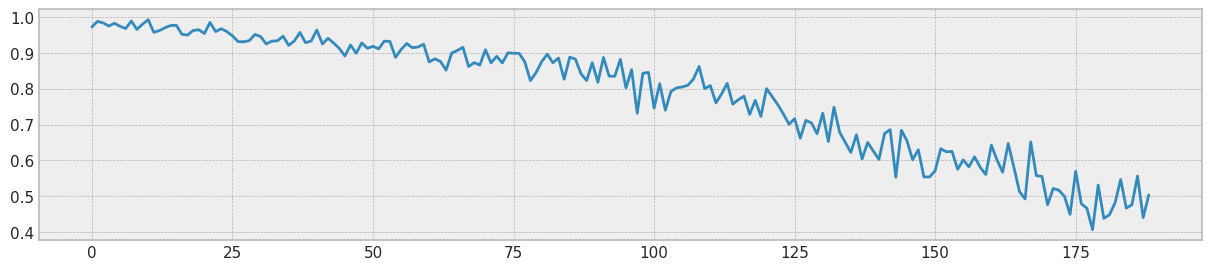

Mean F1 for all data: 0.7833643820519409
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 0.018489] [G loss: 0.584703]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 0.019629] [G loss: 0.504157]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 0.022988] [G loss: 0.436378]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 0.033968] [G loss: 0.364682]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 0.040136] [G loss: 0.293834]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 0.040487] [G loss: 0.240804]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 0.038645] [G loss: 0.201636]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 0.036420] [G loss: 0.172037]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 0.034431] [G loss: 0.149101]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 0.032889] [G loss: 0.130767]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 0.031853] [G loss: 0.115743]
[Lambda: 0.200000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 336.84it/s]


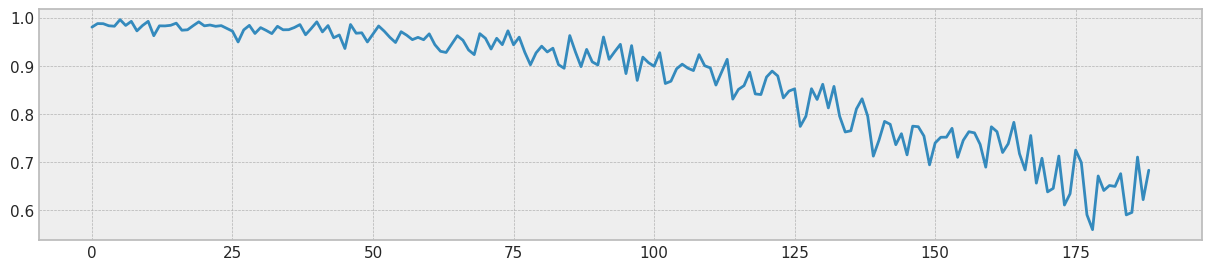

Mean F1 for all data: 0.8695814142813798
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 0.010342] [G loss: 0.588097]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 0.007837] [G loss: 0.508489]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 0.008714] [G loss: 0.442148]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 0.012524] [G loss: 0.375815]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 0.015766] [G loss: 0.306562]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 0.016355] [G loss: 0.251562]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 0.016089] [G loss: 0.210864]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 0.015498] [G loss: 0.180158]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 0.015158] [G loss: 0.156224]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 0.014811] [G loss: 0.137167]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 0.014553] [G loss: 0.121700]
[Lambda: 0.300000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 339.10it/s]


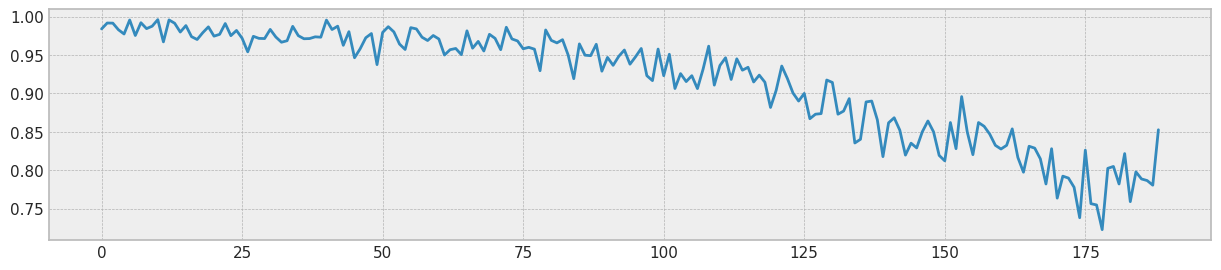

Mean F1 for all data: 0.9156953502345548
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.007799] [G loss: 0.589868]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.003998] [G loss: 0.510795]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 0.004074] [G loss: 0.445162]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 0.005486] [G loss: 0.382395]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 0.007194] [G loss: 0.315968]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.007550] [G loss: 0.259067]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 0.007546] [G loss: 0.217348]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.007504] [G loss: 0.185821]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 0.007392] [G loss: 0.161405]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 0.007369] [G loss: 0.141970]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 0.007398] [G loss: 0.126182]
[Lambda: 0.400000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 340.83it/s]


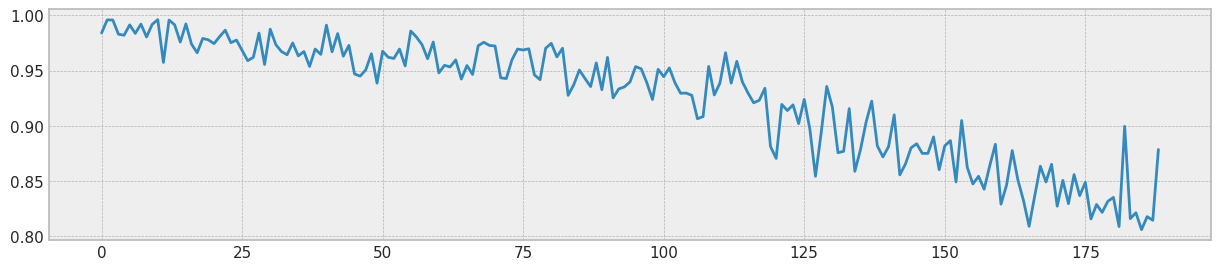

Mean F1 for all data: 0.924911304364104
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.006791] [G loss: 0.590945]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.002412] [G loss: 0.512229]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 0.002156] [G loss: 0.447056]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 0.002640] [G loss: 0.386431]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 0.003465] [G loss: 0.323261]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 0.003699] [G loss: 0.264581]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 0.003740] [G loss: 0.221905]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 0.003696] [G loss: 0.189941]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 0.003674] [G loss: 0.165207]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 0.003734] [G loss: 0.145577]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 0.003784] [G loss: 0.129714]
[Lambda: 0.500000] [Epoch 2400/4000] [mi loss: 0

100%|██████████| 189/189 [00:00<00:00, 248.53it/s]


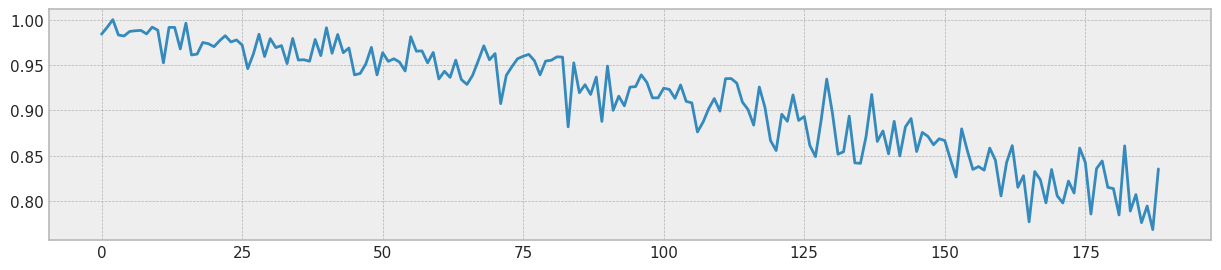

Mean F1 for all data: 0.9114407924489931
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 0.006339] [G loss: 0.591663]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 0.001672] [G loss: 0.513202]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 0.001261] [G loss: 0.448361]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 0.001353] [G loss: 0.388887]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 0.001693] [G loss: 0.328799]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 0.001831] [G loss: 0.269610]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 0.001838] [G loss: 0.225904]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 0.001815] [G loss: 0.193371]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 0.001827] [G loss: 0.168297]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 0.001864] [G loss: 0.148571]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 0.001927] [G loss: 0.132593]
[Lambda: 0.600000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 339.29it/s]


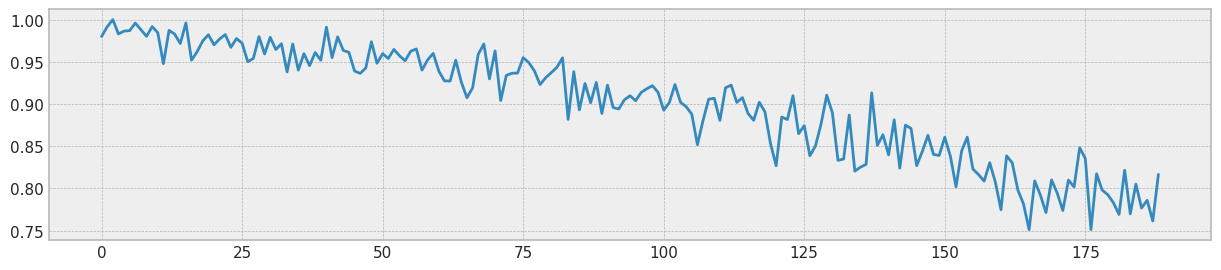

Mean F1 for all data: 0.900023537259777
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 0.006126] [G loss: 0.592189]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 0.001305] [G loss: 0.513911]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 0.000822] [G loss: 0.449310]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 0.000745] [G loss: 0.390311]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 0.000821] [G loss: 0.332271]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 0.000864] [G loss: 0.273652]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 0.000854] [G loss: 0.228932]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 0.000837] [G loss: 0.195970]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 0.000845] [G loss: 0.170716]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 0.000878] [G loss: 0.150909]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 0.000910] [G loss: 0.134964]
[Lambda: 0.700000] [Epoch 2400/4000] [mi loss: 0

100%|██████████| 189/189 [00:00<00:00, 341.91it/s]


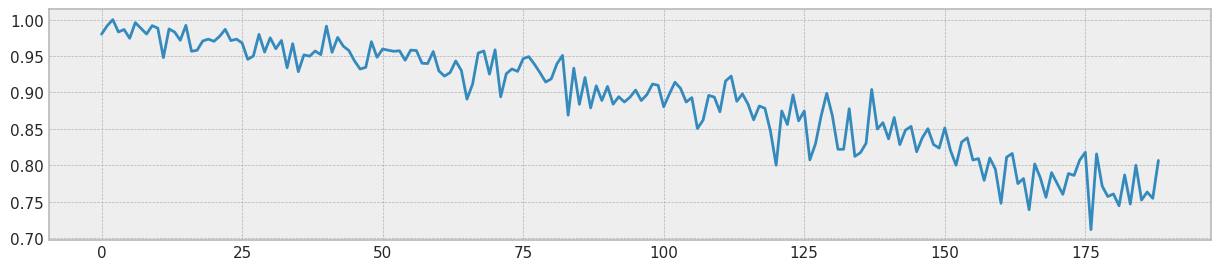

Mean F1 for all data: 0.89094844102321
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 0.006028] [G loss: 0.592582]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 0.001120] [G loss: 0.514450]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 0.000607] [G loss: 0.450032]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 0.000449] [G loss: 0.391394]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 0.000406] [G loss: 0.334911]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 0.000388] [G loss: 0.277870]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 0.000364] [G loss: 0.231717]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 0.000349] [G loss: 0.198266]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 0.000350] [G loss: 0.172791]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 0.000358] [G loss: 0.152966]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 0.000371] [G loss: 0.137015]
[Lambda: 0.800000] [Epoch 2400/4000] [mi loss: 0.

100%|██████████| 189/189 [00:00<00:00, 326.62it/s]


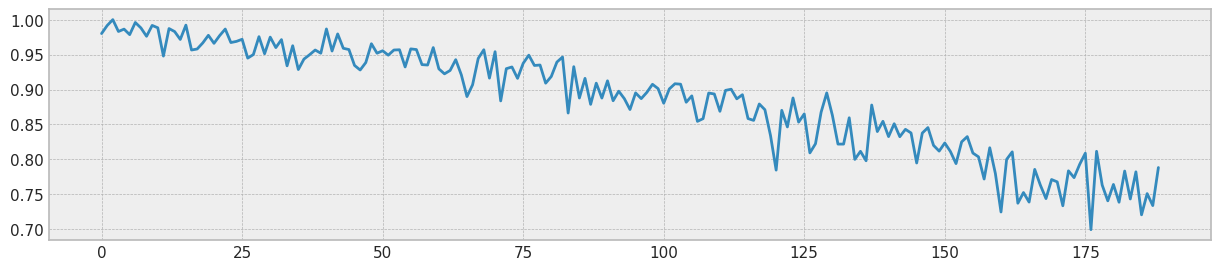

Mean F1 for all data: 0.8855025678733823
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 0.005988] [G loss: 0.592887]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 0.001032] [G loss: 0.514873]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 0.000507] [G loss: 0.450607]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 0.000317] [G loss: 0.392248]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 0.000227] [G loss: 0.337018]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 0.000180] [G loss: 0.282182]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 0.000150] [G loss: 0.234360]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 0.000133] [G loss: 0.200385]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 0.000124] [G loss: 0.174716]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 0.000119] [G loss: 0.154858]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 0.000118] [G loss: 0.138943]
[Lambda: 0.900000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 338.39it/s]


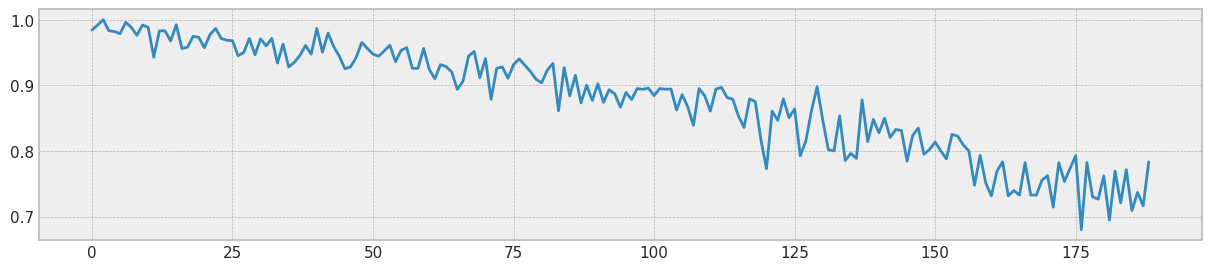

Mean F1 for all data: 0.878191295430785


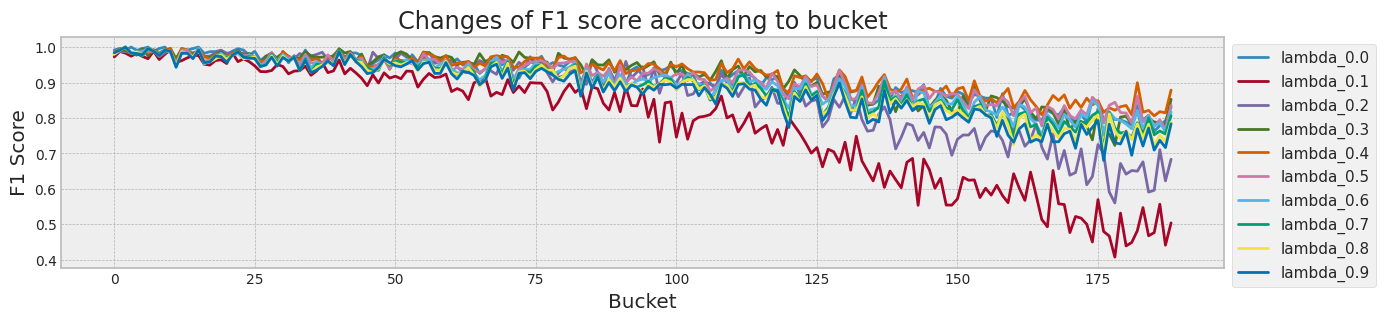

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.002514
1  Case #2 Feature 5  0.875000  0.987952  0.877103  0.752137  0.012903
0                0.0  0.986667  0.991935  0.912956  0.830357  0.296459
1                0.1  0.969957  0.972112  0.783364  0.503597  0.307413
2                0.2  0.973913  0.980080  0.869581  0.683230  0.292253
3                0.3  0.973913  0.984000  0.915695  0.852632  0.292253
4                0.4  0.978166  0.984000  0.924911  0.878505  0.304856
5                0.5  0.973913  0.984000  0.911441  0.835443  0.293090
6                0.6  0.969697  0.980080  0.900024  0.816667  0.280002
7                0.7  0.969697  0.980080  0.890948  0.806584  0.280002
8                0.8  0.969697  0.980080  0.885503  0.788382  0.280002
9                0.9  0.969697  0.984000  0.878191  0.783333  0.280002

In [35]:
seed_everything()

train_result = []

avaible_range = 40000 

train_tensors = Namespace(XS_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y1[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X1[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y1[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X1[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y1[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X1[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y1[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X1[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#lambda_f_set = [0.4,0.5]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.



#lambda_f_set2 = [0.0000089,0.0000090,0.0000091] 
lambda_f_set2 = [1.2] 
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2

    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter,X1[2000:][['x0','x1','x2','x3','z0','b']],y1[2000:])

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3),title='Changes of F1 score according to bucket',ylabel='F1 Score',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    result4_df = pd.DataFrame(result_table2)

    #print(lambda_f2,result4_df)

pd.concat([pd.DataFrame(result_table3),result4_df])

## synthetic data의 생성 (Case #3 MI의 고정, Drift의 증가)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

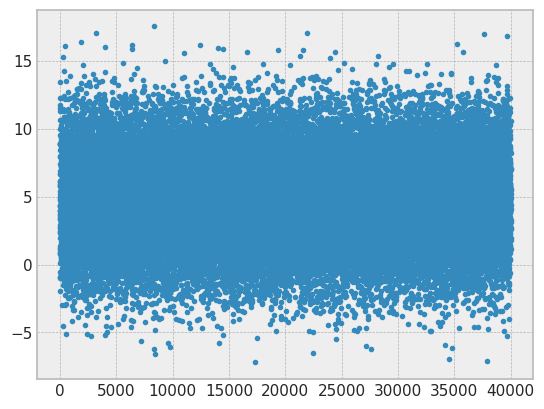

In [36]:
import matplotlib.pyplot as plt

seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = [] 
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x1[ii]))
 
plt.plot(y2_array,'.')

In [37]:
y2 = [1 if y_ > 5 else 0 for y_ in y2_array]

In [38]:
sum(y2)

19015

In [39]:
columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)
mi_scores = make_mi_scores(X2, y2, discrete_features="auto")
print(mi_scores)

x0    0.199733
x1    0.070473
x2    0.020851
x3    0.014964
z0    0.006106
Name: MI Scores, dtype: float64


Bucket size 50


100%|██████████| 50/50 [00:01<00:00, 42.72it/s]


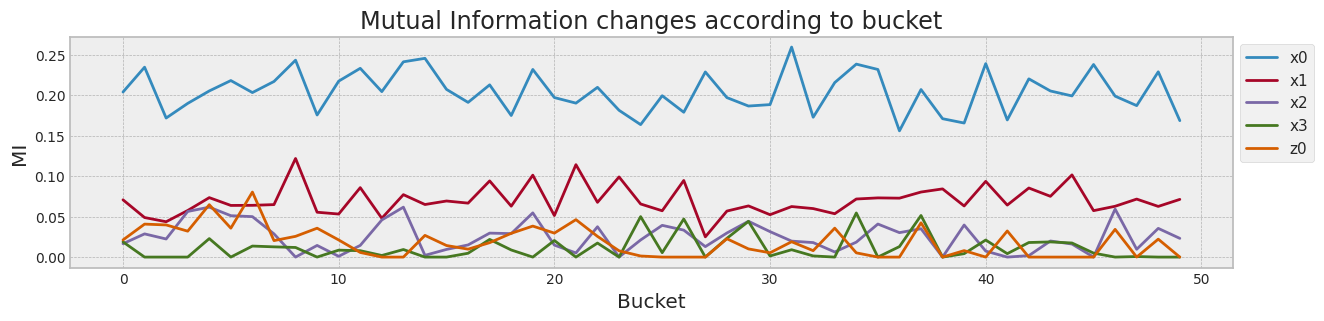

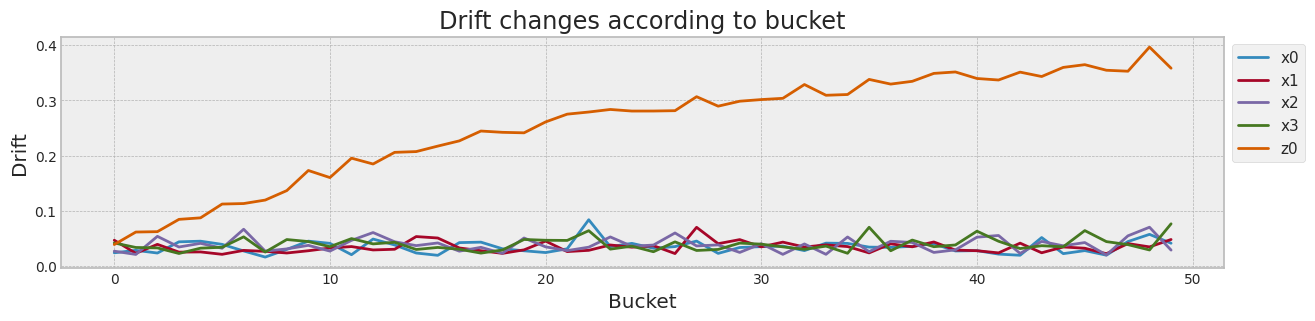

In [40]:
from tqdm import tqdm

bucket_size_array=[50]#[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((x.shape[0]-2000)/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X2[bk*step_size:bk*step_size+step_size], y2[bk*step_size:bk*step_size+step_size], discrete_features="auto")
        ks = __ks_drift(X2[0:1800].values,X2[bk*step_size+2000:bk*step_size+step_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col]) 
            DRF[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    df_mis.plot(figsize=(15,3),title='Mutual Information changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    df_drf.plot(figsize=(15,3),title='Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

## 학습 및 전체 예측

cuda:0


100%|██████████| 1000/1000 [00:23<00:00, 41.74it/s]


MSE: 0.09
RMSE: 0.31


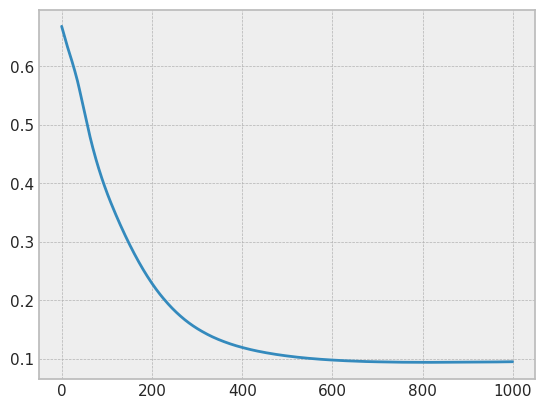

In [41]:
import copy
import torch.optim as optim
 
seed_everything()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y2[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y2[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

100%|██████████| 189/189 [00:00<00:00, 534.15it/s]


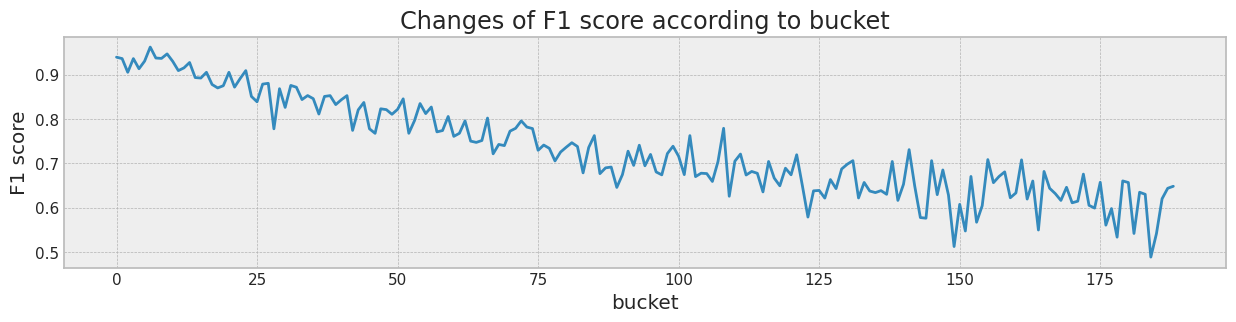

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.002514
1  Case #2 Feature 5  0.875000  0.987952  0.877103  0.752137  0.012903
2  Case #3 Feature 5  0.969697  0.939394  0.731917  0.648148  0.000000

In [42]:
XT = X2[2000:][['x0','x1','x2','x3','z0']]
yT = y2[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.ylabel('F1 score')
    plt.xlabel('bucket')
    plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3['lambda'].append('Case #3 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

## Case #3의 feature 4

cuda:0


100%|██████████| 1000/1000 [00:24<00:00, 41.19it/s]


MSE: 0.30
RMSE: 0.55


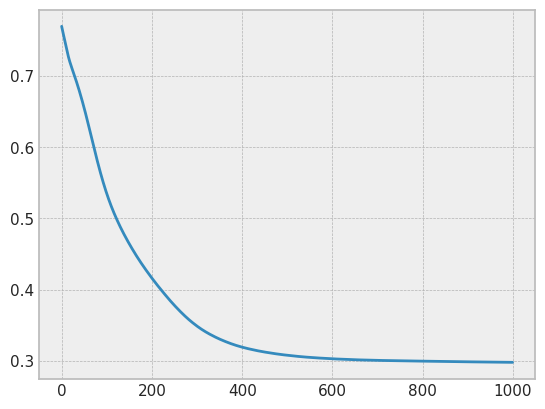

In [43]:
import copy
import torch.optim as optim
 
seed_everything()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y2[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y2[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)
 
# Define the model
model = nn.Sequential(
    nn.Linear(4, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

100%|██████████| 189/189 [00:00<00:00, 516.99it/s]


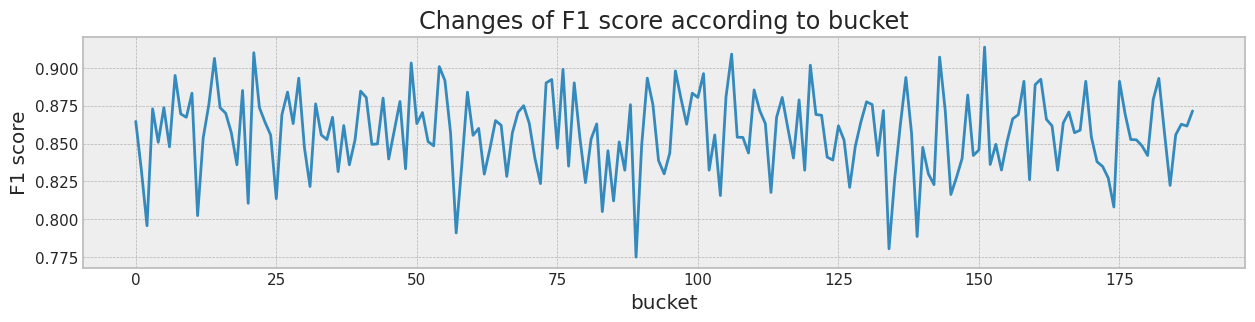

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.002514
1  Case #2 Feature 5  0.875000  0.987952  0.877103  0.752137  0.012903
2  Case #3 Feature 5  0.969697  0.939394  0.731917  0.648148  0.000000
3  Case #3 Feature 4  0.969697  0.864583  0.857218  0.871560  0.000000

In [44]:
XT = X2[2000:][['x0','x1','x2','x3']]
yT = y2[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.ylabel('F1 score')
    plt.xlabel('bucket')
    plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3['lambda'].append('Case #3 Feature 4')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

In [45]:
X2['b'] = [int(b) for b in X2.index.values]
X2

x0        x1        x2        x3        z0      b
0      1.877314  1.185467 -0.002710  1.124792  0.414883      0
1      2.846794  0.461018  1.213784  1.282154  1.456334      1
2      2.232850  0.876278  2.307393  2.019052  0.837239      2
3     -0.198843  2.579531  0.078102  1.019118  1.277169      3
4      1.618080  1.683218  1.826908  0.697273  0.839361      4
...         ...       ...       ...       ...       ...    ...
39995 -0.321489  0.268097 -0.178799  1.410070 -2.562643  39995
39996 -0.037401  1.055617  0.084065  1.252068 -2.160164  39996
39997  2.262545 -0.256564  1.445491  1.256208  0.476012  39997
39998  0.823467  1.489013 -0.191516 -0.238143  2.303669  39998
39999  2.024101  2.498025  0.198514  2.241146  0.462217  39999

[40000 rows x 6 columns]

cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 39.985016] [G loss: 0.514161]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 221.707062] [G loss: 0.224302]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 492.402893] [G loss: 0.120786]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 772.254089] [G loss: 0.080998]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 1013.021545] [G loss: 0.063482]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 1227.365845] [G loss: 0.053389]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 1431.723755] [G loss: 0.047059]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 1631.553589] [G loss: 0.043259]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 1820.705200] [G loss: 0.040569]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 1993.556030] [G loss: 0.038543]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 2163.654785] [G loss: 0.037128]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 2319.914795] 

100%|██████████| 189/189 [00:00<00:00, 341.64it/s]


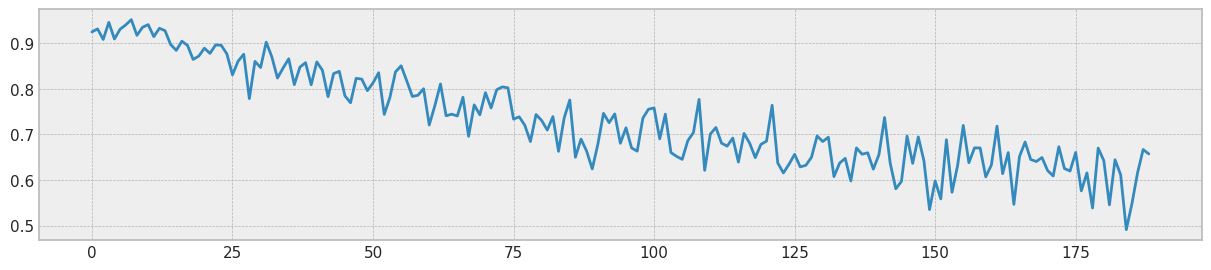

Mean F1 for all data: 0.7325707203838511
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 0.027311] [G loss: 0.628979]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 0.088878] [G loss: 0.566033]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 0.156974] [G loss: 0.493856]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 0.186313] [G loss: 0.432730]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 0.186892] [G loss: 0.386816]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 0.192164] [G loss: 0.346667]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 0.223526] [G loss: 0.302329]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 0.245491] [G loss: 0.260293]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 0.249261] [G loss: 0.226569]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 0.245329] [G loss: 0.199459]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 0.238208] [G loss: 0.177344]
[Lambda: 0.100000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 338.66it/s]


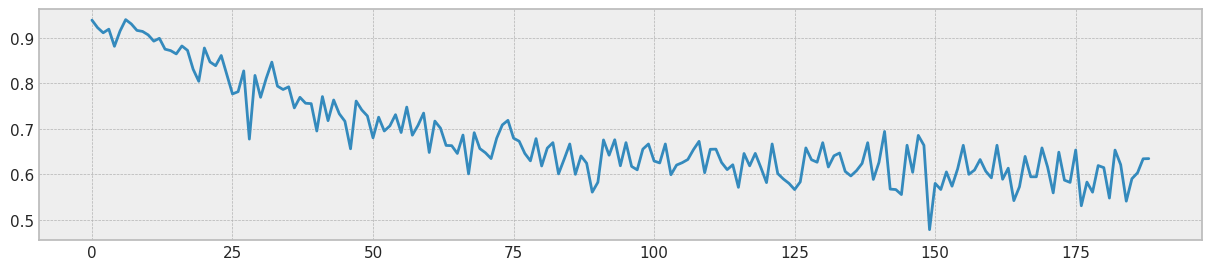

Mean F1 for all data: 0.6816085075745206
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 0.007531] [G loss: 0.634089]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 0.020116] [G loss: 0.581019]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 0.039297] [G loss: 0.518655]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 0.051730] [G loss: 0.459146]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 0.056176] [G loss: 0.409840]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 0.058266] [G loss: 0.369240]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 0.065306] [G loss: 0.330175]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 0.076050] [G loss: 0.290616]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 0.083040] [G loss: 0.255340]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 0.084951] [G loss: 0.225961]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 0.084217] [G loss: 0.201788]
[Lambda: 0.200000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 334.01it/s]


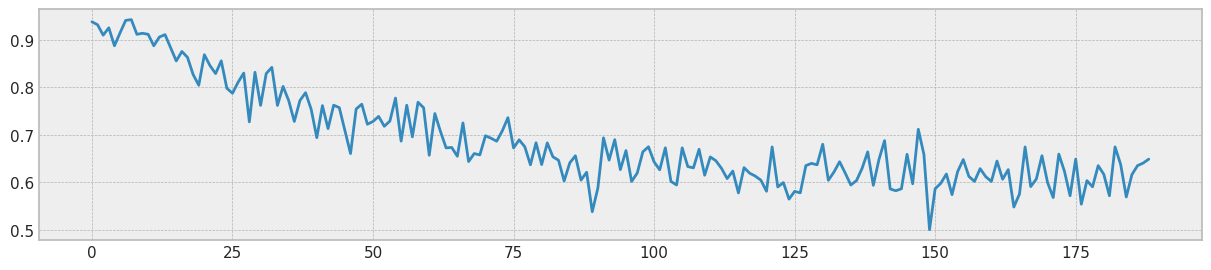

Mean F1 for all data: 0.6879255408383158
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 0.004502] [G loss: 0.635791]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 0.007242] [G loss: 0.586762]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 0.014635] [G loss: 0.529495]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 0.020535] [G loss: 0.472046]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 0.023199] [G loss: 0.422465]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 0.024126] [G loss: 0.381781]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 0.026288] [G loss: 0.345097]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 0.031530] [G loss: 0.308472]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 0.035535] [G loss: 0.274382]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 0.038153] [G loss: 0.244181]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 0.038726] [G loss: 0.218851]
[Lambda: 0.300000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 332.00it/s]


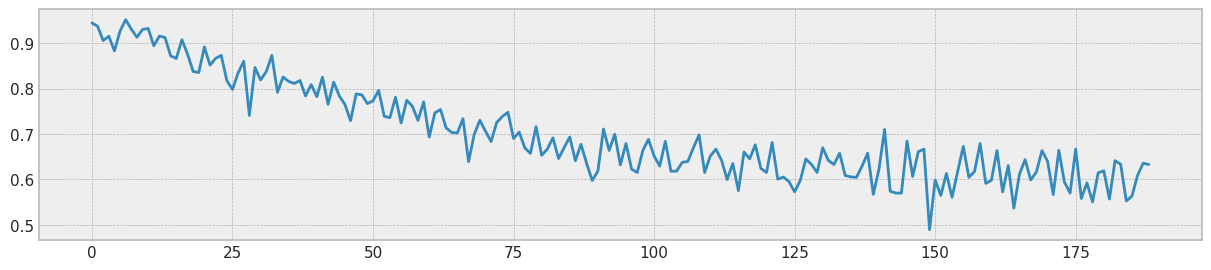

Mean F1 for all data: 0.7010812074993156
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.003691] [G loss: 0.636680]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.003238] [G loss: 0.589740]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 0.006336] [G loss: 0.535522]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 0.009205] [G loss: 0.479909]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 0.010754] [G loss: 0.430474]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.011388] [G loss: 0.389581]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 0.012335] [G loss: 0.353824]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.014506] [G loss: 0.319742]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 0.016943] [G loss: 0.286960]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 0.018560] [G loss: 0.257200]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 0.019258] [G loss: 0.231295]
[Lambda: 0.400000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 344.47it/s]


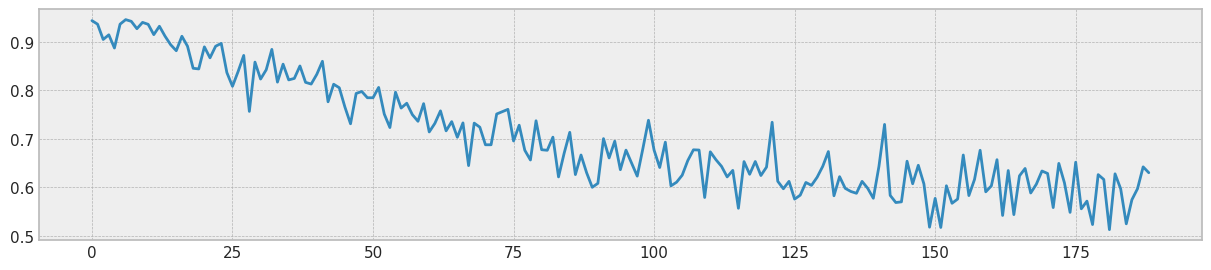

Mean F1 for all data: 0.7026332590837118
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.003430] [G loss: 0.637222]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.001622] [G loss: 0.591591]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 0.002991] [G loss: 0.539268]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 0.004369] [G loss: 0.485095]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 0.005189] [G loss: 0.436095]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 0.005526] [G loss: 0.395191]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 0.006027] [G loss: 0.359932]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 0.006969] [G loss: 0.327399]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 0.008204] [G loss: 0.296116]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 0.009243] [G loss: 0.266866]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 0.009861] [G loss: 0.240826]
[Lambda: 0.500000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 339.11it/s]


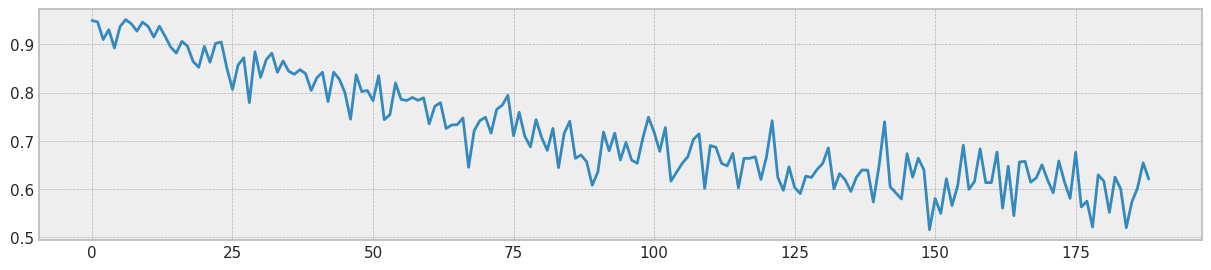

Mean F1 for all data: 0.718166075559592
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 0.003352] [G loss: 0.637582]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 0.000898] [G loss: 0.592853]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 0.001435] [G loss: 0.541901]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 0.002039] [G loss: 0.488861]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 0.002427] [G loss: 0.440311]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 0.002629] [G loss: 0.399447]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 0.002861] [G loss: 0.364576]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 0.003297] [G loss: 0.333001]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 0.003942] [G loss: 0.302822]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 0.004500] [G loss: 0.274342]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 0.004883] [G loss: 0.248519]
[Lambda: 0.600000] [Epoch 2400/4000] [mi loss: 0

100%|██████████| 189/189 [00:00<00:00, 339.10it/s]


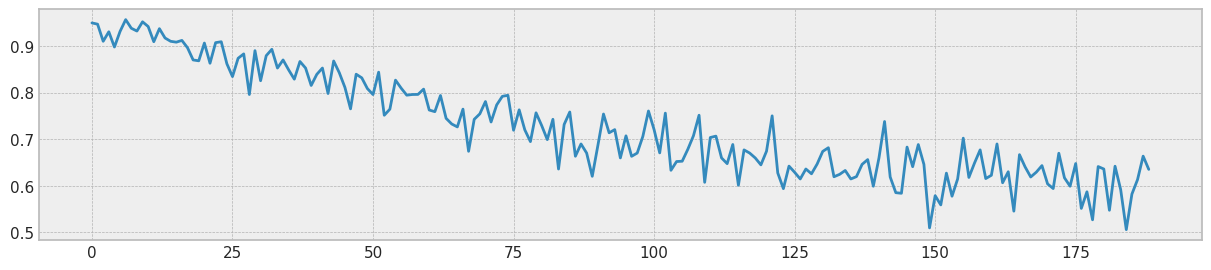

Mean F1 for all data: 0.7274206031521622
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 0.003346] [G loss: 0.637841]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 0.000560] [G loss: 0.593758]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 0.000682] [G loss: 0.543829]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 0.000906] [G loss: 0.491638]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 0.001075] [G loss: 0.443463]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 0.001166] [G loss: 0.402746]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 0.001260] [G loss: 0.368183]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 0.001429] [G loss: 0.337352]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 0.001713] [G loss: 0.308226]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 0.002008] [G loss: 0.280457]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 0.002201] [G loss: 0.254940]
[Lambda: 0.700000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 329.08it/s]


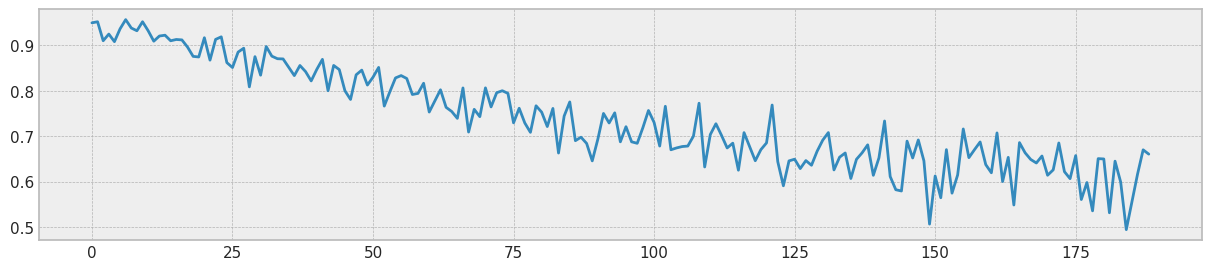

Mean F1 for all data: 0.7376648510328194
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 0.003368] [G loss: 0.638031]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 0.000403] [G loss: 0.594443]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 0.000324] [G loss: 0.545298]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 0.000369] [G loss: 0.493751]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 0.000416] [G loss: 0.445932]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 0.000441] [G loss: 0.405374]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 0.000466] [G loss: 0.371057]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 0.000524] [G loss: 0.340710]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 0.000616] [G loss: 0.312442]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 0.000724] [G loss: 0.285531]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 0.000807] [G loss: 0.260358]
[Lambda: 0.800000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 309.29it/s]


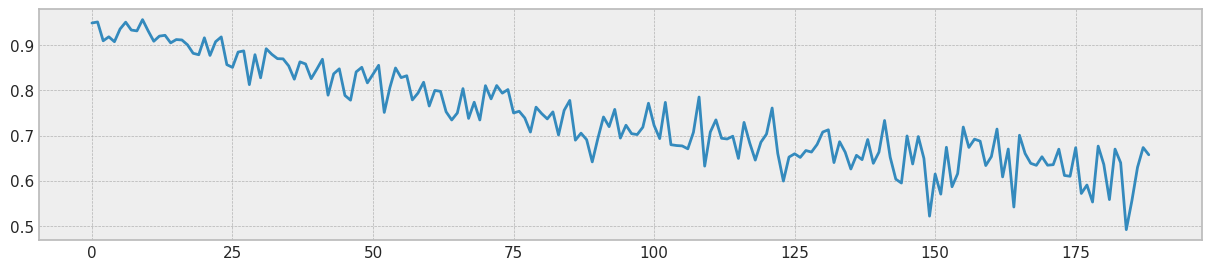

Mean F1 for all data: 0.7429497285497785
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 0.003402] [G loss: 0.638184]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 0.000340] [G loss: 0.595001]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 0.000175] [G loss: 0.546464]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 0.000137] [G loss: 0.495490]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 0.000128] [G loss: 0.447984]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 0.000124] [G loss: 0.407554]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 0.000123] [G loss: 0.373427]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 0.000129] [G loss: 0.343513]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 0.000143] [G loss: 0.315895]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 0.000164] [G loss: 0.289717]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 0.000182] [G loss: 0.265028]
[Lambda: 0.900000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 324.85it/s]


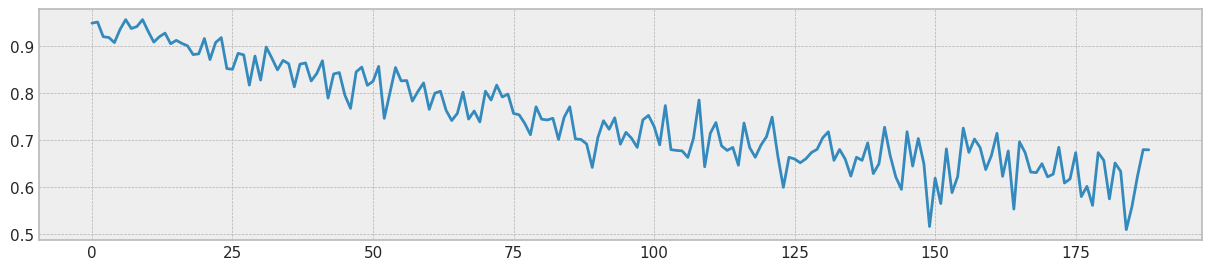

Mean F1 for all data: 0.744149331704561


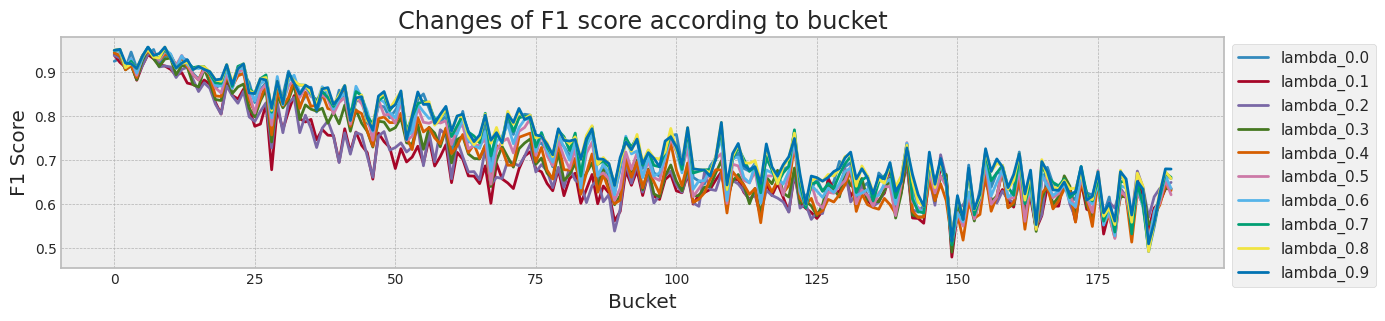

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.002514
1  Case #2 Feature 5  0.875000  0.987952  0.877103  0.752137  0.012903
2  Case #3 Feature 5  0.969697  0.939394  0.731917  0.648148  0.000000
3  Case #3 Feature 4  0.969697  0.864583  0.857218  0.871560  0.000000
0                0.0  0.939024  0.924623  0.732571  0.657143  0.139956
1                0.1  0.958084  0.938776  0.681609  0.634538  0.116553
2                0.2  0.946108  0.938144  0.687926  0.648649  0.114162
3                0.3  0.952381  0.944162  0.701081  0.632911  0.103701
4                0.4  0.952381  0.944162  0.702633  0.630137  0.108794
5                0.5  0.958084  0.949495  0.718166  0.620370  0.105645
6                0.6  0.951807  0.949495  0.727421  0.635071  0.099694
7                0.7  0.946108  0.949495  0.737665  0.660377  0.102946
8                0.8  0.946108  0.949495  0.742950  0.657277  0.102946
9                0.9  0.946108  0.949495  0.744149  0.679070  0.102946

In [46]:

avaible_range = 40000 

train_tensors = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#lambda_f_set = [0.4,0.5]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.



#lambda_f_set2 = [0.0000089,0.0000090,0.0000091] 
lambda_f_set2 = [1.2] 
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2

    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter,X2[2000:][['x0','x1','x2','x3','z0','b']],y2[2000:])

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3),title='Changes of F1 score according to bucket',ylabel='F1 Score',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    result4_df = pd.DataFrame(result_table2)

    #print(lambda_f2,result4_df)

pd.concat([pd.DataFrame(result_table3),result4_df])

## I(y^,z)을 최소화 하도록 학습
+ MINE을 적용, I(y^,z) 을 최소화 한다.

In [47]:
H=40
minibatch = 1000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2  

In [48]:

def test_model2(generator_, tX, ty, s1):
    generator_.eval()


    y_hat = generator_(tX)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    
    f1 = f1_score(ty.cpu().data.numpy(),y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4].cpu().data.numpy(),columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [49]:

def test_all_data2(generator,XT,yT):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    #XT = X[train_size:][['x0','x1','x2','x3','z0','b']]
    #yT = y[train_size:]
    print('XT.shape',XT.shape)
    bucket_size_array=[200]
    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
            #xs = adapter1(tmp_x[:,0:5],tmp_x[:,5].reshape(-1,1)/avaible_range)
            predicted_y = generator(tmp_x[:,0:5])
            predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

In [50]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model2(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):

    seed_everything()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    s1_train = train_tensors.s1_train.to(device)
    
    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    s1_test = test_tensors.s1_test.to(device)
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator().to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net().to(device)
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)
    minibatch = 1000

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        gen_y = generator(XS_train[:,0:5]).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        # -------------------------------
        #  MINE
        # -------------------------------
        s = np.random.choice(XS_train.shape[0],minibatch)
        x_sample = s1_train[s].reshape(-1,1) #torch.clone(s1_train[s].reshape(-1,1)) #Variable(torch.from_numpy(s1_train[s].data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = y_train[s].reshape(-1,1) #Variable(torch.from_numpy(y2).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = y_train[np.random.permutation(s)].reshape(-1,1) #Variable(torch.from_numpy(np.random.permutation(y2)).type(torch.FloatTensor), requires_grad = True)    

        y2_sample = gen_y[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
        y2_shuffle = gen_y[np.random.permutation(s)] # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)    


        ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        ret2 = torch.mean(mine(x_sample, y2_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y2_shuffle))))

        # ret2(y의 샘플)는 maximize 하야 하고
        # ret1(y^의 샘플)는 0으로 minimize 해야 한다.!!! 
        mi_loss = - ret1 + torch.abs(ret2)

        mi_losses.append(-ret2)

        optimizer_G.zero_grad()
        optimizer_M.zero_grad()

        loss = (1-lambda_f) * g_loss +  lambda_f * mi_loss * alpha #* 0.05

        loss.backward()
        optimizer_G.step()
        optimizer_M.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model2(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator

cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 0.005709] [G loss: 0.678826]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 0.005749] [G loss: 0.640856]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 0.006124] [G loss: 0.600535]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 0.005923] [G loss: 0.554298]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 0.006693] [G loss: 0.504537]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 0.008113] [G loss: 0.456716]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 0.008625] [G loss: 0.415156]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 0.009183] [G loss: 0.380202]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 0.010561] [G loss: 0.350321]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 0.011203] [G loss: 0.323463]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 0.013376] [G loss: 0.298711]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 0.012336] [G loss: 0.275446]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 0.014105] [G loss: 0.253610]
[Lambda: 0.0

100%|██████████| 189/189 [00:00<00:00, 483.98it/s]


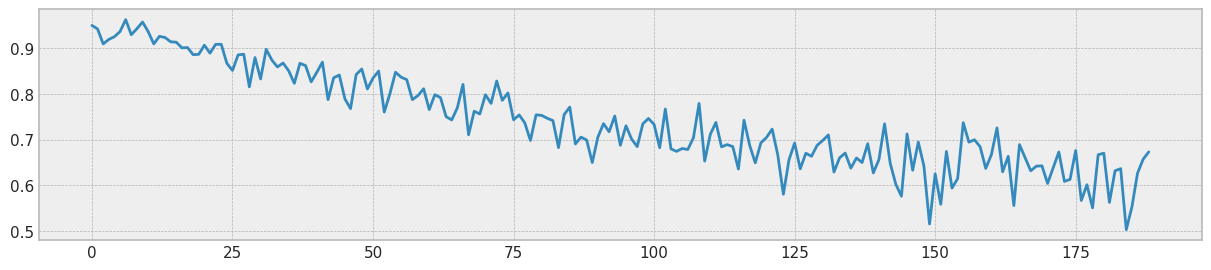

Mean F1 for all data: 0.7425338195004529
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 0.005709] [G loss: 0.678826]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: -0.000354] [G loss: 0.640869]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 0.000700] [G loss: 0.600620]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 0.000785] [G loss: 0.554475]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 0.000614] [G loss: 0.504811]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: -0.006109] [G loss: 0.456991]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 0.004772] [G loss: 0.415324]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 0.005528] [G loss: 0.380249]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 0.001714] [G loss: 0.350342]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: -0.002837] [G loss: 0.323568]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: -0.002775] [G loss: 0.298964]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 0.011028] [G loss: 0.275845]
[Lambda: 0.100000] [Epoch 2400/4000] [mi lo

100%|██████████| 189/189 [00:00<00:00, 491.92it/s]


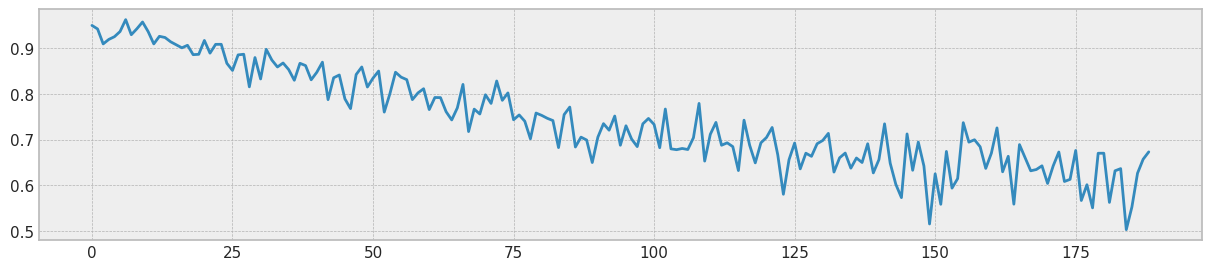

Mean F1 for all data: 0.7429806060050251
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 0.005709] [G loss: 0.678826]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: -0.000371] [G loss: 0.640890]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 0.000704] [G loss: 0.600797]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 0.000667] [G loss: 0.554908]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 0.000058] [G loss: 0.505598]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: -0.006741] [G loss: 0.458051]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 0.004681] [G loss: 0.416400]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 0.005502] [G loss: 0.381300]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 0.001983] [G loss: 0.351466]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: -0.002423] [G loss: 0.324913]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: -0.002385] [G loss: 0.300633]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 0.011504] [G loss: 0.277882]
[Lambda: 0.200000] [Epoch 2400/4000] [mi lo

100%|██████████| 189/189 [00:00<00:00, 490.07it/s]


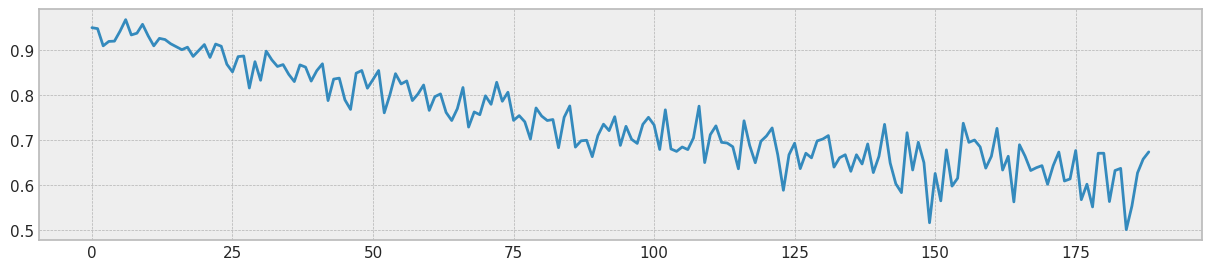

Mean F1 for all data: 0.743694682074376
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 0.005709] [G loss: 0.678826]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: -0.000408] [G loss: 0.640924]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 0.000525] [G loss: 0.601098]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 0.000361] [G loss: 0.555687]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: -0.000462] [G loss: 0.507013]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: -0.007136] [G loss: 0.460024]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 0.004478] [G loss: 0.418527]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 0.005426] [G loss: 0.383517]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 0.001823] [G loss: 0.353851]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: -0.002273] [G loss: 0.327680]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: -0.001628] [G loss: 0.303900]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 0.013009] [G loss: 0.281823]
[Lambda: 0.300000] [Epoch 2400/4000] [mi lo

100%|██████████| 189/189 [00:00<00:00, 490.77it/s]


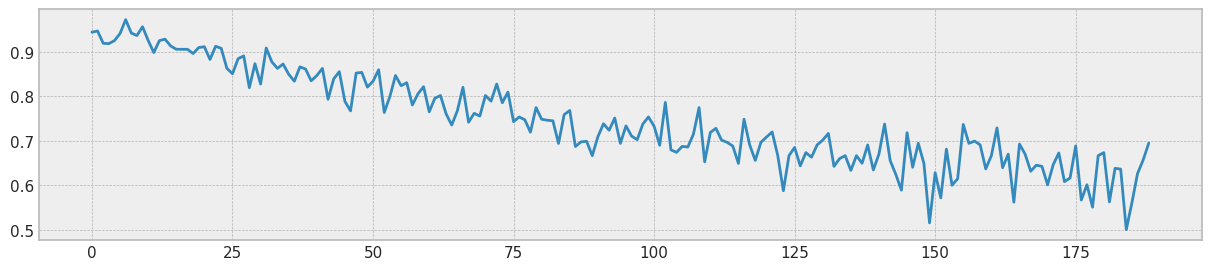

Mean F1 for all data: 0.7465385655256698
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 0.005709] [G loss: 0.678826]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: -0.000418] [G loss: 0.640976]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.000584] [G loss: 0.601599]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 0.000234] [G loss: 0.556927]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: -0.000541] [G loss: 0.509160]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: -0.007266] [G loss: 0.463046]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.004061] [G loss: 0.422022]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 0.005096] [G loss: 0.387314]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.001800] [G loss: 0.357887]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: -0.000998] [G loss: 0.332192]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: -0.000567] [G loss: 0.309131]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 0.012182] [G loss: 0.287875]
[Lambda: 0.400000] [Epoch 2400/4000] [mi l

100%|██████████| 189/189 [00:00<00:00, 482.39it/s]


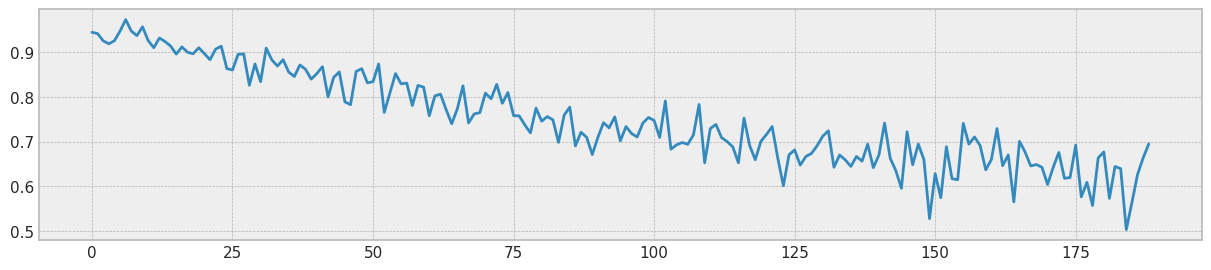

Mean F1 for all data: 0.7507214856499689
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 0.005709] [G loss: 0.678826]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: -0.000439] [G loss: 0.641066]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.000435] [G loss: 0.602444]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: -0.000051] [G loss: 0.558902]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: -0.000859] [G loss: 0.512395]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: -0.007426] [G loss: 0.467530]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 0.003574] [G loss: 0.427184]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 0.005231] [G loss: 0.392943]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 0.001958] [G loss: 0.363868]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: -0.000380] [G loss: 0.338713]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 0.000830] [G loss: 0.316429]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 0.014922] [G loss: 0.296096]
[Lambda: 0.500000] [Epoch 2400/4000] [mi l

100%|██████████| 189/189 [00:00<00:00, 485.50it/s]


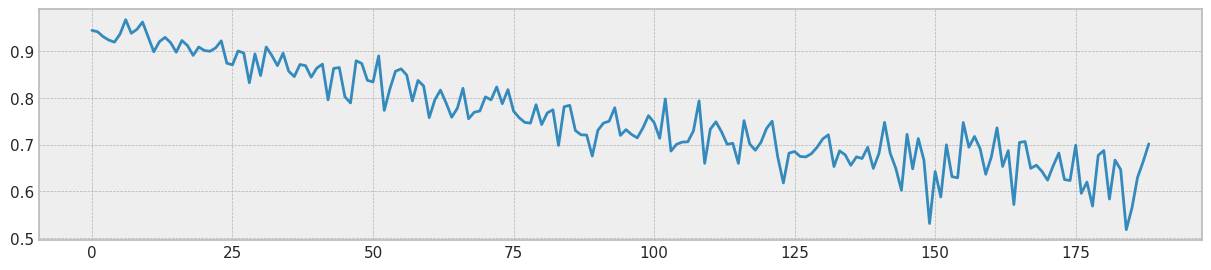

Mean F1 for all data: 0.7587252967013361
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 0.005709] [G loss: 0.678826]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: -0.000447] [G loss: 0.641223]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 0.000445] [G loss: 0.603789]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: -0.000206] [G loss: 0.562103]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: -0.001404] [G loss: 0.517602]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: -0.007246] [G loss: 0.474335]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 0.003125] [G loss: 0.435021]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 0.005487] [G loss: 0.401350]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 0.002331] [G loss: 0.372684]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: -0.000104] [G loss: 0.348034]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 0.001648] [G loss: 0.326468]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 0.015601] [G loss: 0.307059]
[Lambda: 0.600000] [Epoch 2400/4000] [mi l

100%|██████████| 189/189 [00:00<00:00, 495.74it/s]


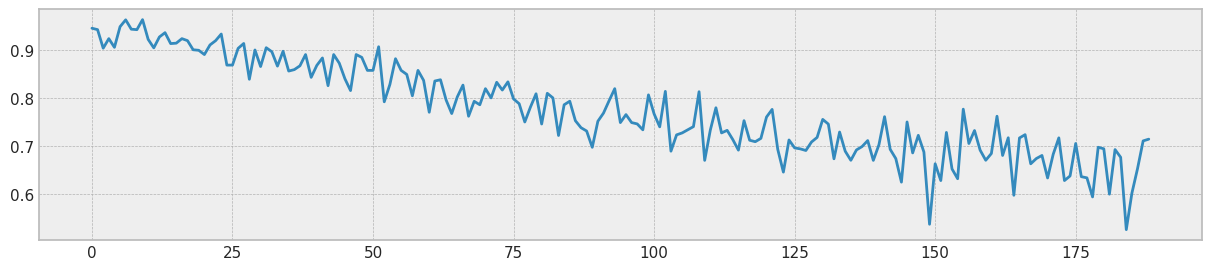

Mean F1 for all data: 0.7747928747313226
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 0.005709] [G loss: 0.678826]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: -0.000330] [G loss: 0.641515]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 0.000444] [G loss: 0.606355]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: -0.000306] [G loss: 0.567515]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: -0.001635] [G loss: 0.526160]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: -0.007313] [G loss: 0.485277]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 0.002749] [G loss: 0.447557]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 0.004976] [G loss: 0.414783]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 0.001972] [G loss: 0.386524]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: -0.000248] [G loss: 0.362166]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 0.001338] [G loss: 0.341265]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 0.016522] [G loss: 0.322594]
[Lambda: 0.700000] [Epoch 2400/4000] [mi l

100%|██████████| 189/189 [00:00<00:00, 483.77it/s]


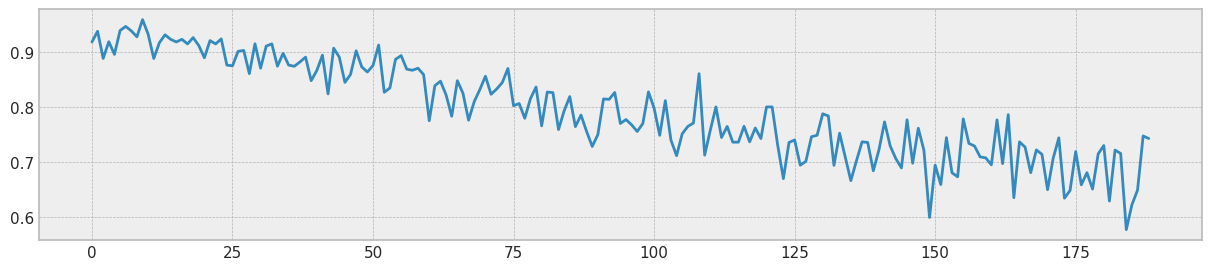

Mean F1 for all data: 0.7937426500014935
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 0.005709] [G loss: 0.678826]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: -0.000390] [G loss: 0.642232]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 0.000426] [G loss: 0.611156]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: -0.000253] [G loss: 0.578392]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: -0.002210] [G loss: 0.542284]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: -0.006296] [G loss: 0.505625]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 0.001978] [G loss: 0.470786]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 0.004146] [G loss: 0.439484]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 0.001655] [G loss: 0.411573]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: -0.000729] [G loss: 0.387155]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 0.001626] [G loss: 0.365966]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 0.014752] [G loss: 0.347496]
[Lambda: 0.800000] [Epoch 2400/4000] [mi l

100%|██████████| 189/189 [00:00<00:00, 492.95it/s]


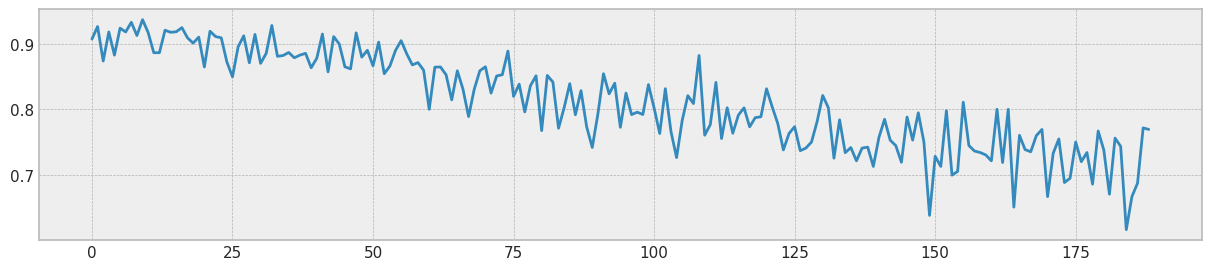

Mean F1 for all data: 0.8123813021432756
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 0.005709] [G loss: 0.678826]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: -0.000437] [G loss: 0.644659]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 0.000376] [G loss: 0.621138]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: -0.000182] [G loss: 0.600876]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: -0.002428] [G loss: 0.579622]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: -0.003035] [G loss: 0.556395]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 0.001366] [G loss: 0.531998]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 0.003493] [G loss: 0.507142]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 0.000287] [G loss: 0.482156]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: -0.000892] [G loss: 0.458531]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 0.001560] [G loss: 0.437345]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 0.010345] [G loss: 0.417971]
[Lambda: 0.900000] [Epoch 2400/4000] [mi l

100%|██████████| 189/189 [00:00<00:00, 493.37it/s]


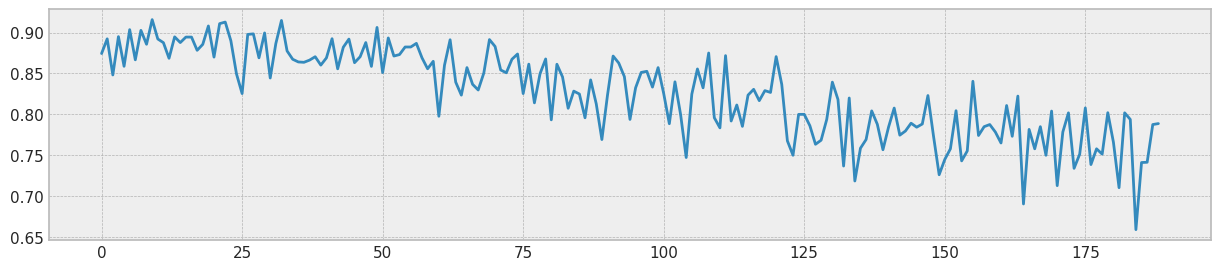

Mean F1 for all data: 0.8268861873196384


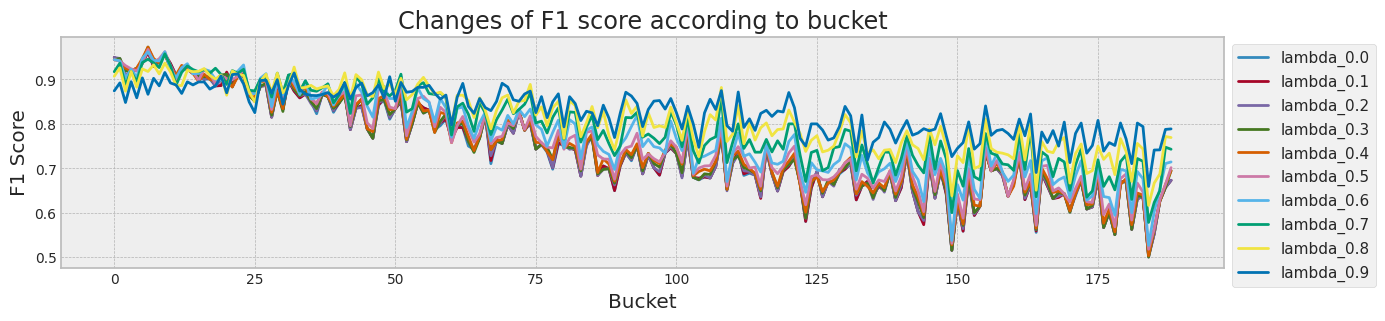

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.002514
1  Case #2 Feature 5  0.875000  0.987952  0.877103  0.752137  0.012903
2  Case #3 Feature 5  0.969697  0.939394  0.731917  0.648148  0.000000
3  Case #3 Feature 4  0.969697  0.864583  0.857218  0.871560  0.000000
0                0.0  0.934911  0.949495  0.742534  0.672986  0.098813
1                0.1  0.934911  0.949495  0.742981  0.672986  0.098813
2                0.2  0.934911  0.949495  0.743695  0.672986  0.098813
3                0.3  0.928571  0.944724  0.746539  0.694836  0.091734
4                0.4  0.928571  0.944724  0.750721  0.694836  0.073785
5                0.5  0.915663  0.944724  0.758725  0.701422  0.063917
6                0.6  0.927711  0.944724  0.774793  0.714286  0.047634
7                0.7  0.915663  0.917526  0.793743  0.742857  0.031625
8                0.8  0.903614  0.907216  0.812381  0.769231  0.020495
9                0.9  0.862275  0.874372  0.826886  0.788732  0.000000

In [51]:
train_tensors = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

#lambda_f_set = [0.5] #[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
#lambda_f_set = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30] # Lambda value for the fairness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:

    f1,mi,last_generator = train_model2(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=1.0)
    result_table[f'lambda_{lambda_f}'] = test_all_data2(last_generator,X2[2000:][['x0','x1','x2','x3','z0','b']], y2[2000:])

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3),title='Changes of F1 score according to bucket',ylabel='F1 Score',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()
result4_df = pd.DataFrame(result_table2)

pd.concat([pd.DataFrame(result_table3),result4_df])

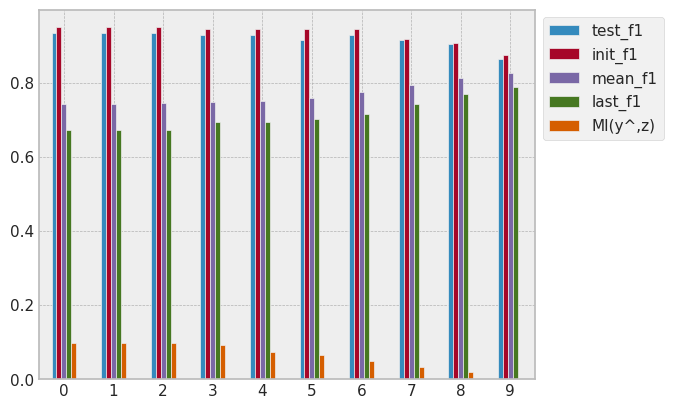

In [52]:
result4_df[['test_f1','init_f1','mean_f1','last_f1','MI(y^,z)']].plot.bar(rot=0)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

## b를 대입하여 b가 작을때는 I(y^,z)을 최대화, b가 커질수록I(y^,z)을 최소화 하도록 학습
+ MINE을 적용, I(G(x,b=0),z) 을 최대화, I(G(x,b=1),z) 을 최소화 한다.

In [53]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model3(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):

    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    s1_train = train_tensors.s1_train.to(device)
    
    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    s1_test = test_tensors.s1_test.to(device)
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    a_losses =[]
    g_losses =[]
    mi_losses1 = []
    mi_losses2 = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator().to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net().to(device)
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 500

    for epoch in range(n_epochs):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------
        xs = adapter(XS_train[:,0:5],XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
        a_loss = torch.sum(mse_loss(xs, XS_train[:,0:5]))
        a_losses.append(a_loss)
        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        # -------------------------------
        #  MINE
        # -------------------------------
        #Sample을 앞 뒤 반으로 나눈다.
        sa = np.random.choice(range(0,int(XS_train.shape[0]/2)),minibatch)
        sb = np.random.choice(range(int(XS_train.shape[0]/2),XS_train.shape[0]),minibatch)
        
        x_sample = s1_train[sa].reshape(-1,1) 
        y_sample = gen_y[sa] # y_train[s].reshape(-1,1) #gen_y0[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = gen_y[np.random.permutation(sa)] #y_train[np.random.permutation(s)].reshape(-1,1) # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)    
        
        x2_sample = s1_train[sb].reshape(-1,1) 
        y2_sample = gen_y[sb]
        y2_shuffle = gen_y[np.random.permutation(sb)] #Variable(torch.from_numpy(np.random.permutation(y2)).type(torch.FloatTensor), requires_grad = True)    

        ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        ret2 = torch.mean(mine(x2_sample, y2_sample)) - torch.log(torch.mean(torch.exp(mine(x2_sample, y2_shuffle))))

        # ret1(bucket 앞부분의 Sample에 대한 MI)는 maximize 하야 하고
        # ret2(bucket 뒷부분의 Sample에 대한 MI)는 0으로 minimize 해야 한다.!!! => 즉, bucket의 증가, 시간이 지난수록 MI를 낮추는 방향으로 학습을 진행 하는 것!
        mi_loss = - ret1 + torch.abs(ret2)
        mi_losses1.append(-ret1)
        mi_losses2.append(-ret2)


        optimizer_A.zero_grad()
        optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        loss = (1-lambda_f) * (g_loss + a_loss) + lambda_f * mi_loss 

        loss.backward()
        optimizer_G.step()
        optimizer_M.step()
        optimizer_A.step()            

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss1: %f] [mi loss2: %f] [A loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses1[-1], mi_losses2[-1], a_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator,adapter

lambda_f2 1.0
cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [mi loss1: 0.005351] [mi loss2: 0.005623] [A loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss1: 0.006123] [mi loss2: 0.005731] [A loss: 0.003513] [G loss: 0.637001]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss1: 0.004856] [mi loss2: 0.006532] [A loss: 0.002195] [G loss: 0.590839]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss1: 0.006070] [mi loss2: 0.006063] [A loss: 0.004194] [G loss: 0.537735]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss1: 0.008339] [mi loss2: 0.005659] [A loss: 0.006116] [G loss: 0.482964]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss1: 0.009192] [mi loss2: 0.008287] [A loss: 0.007238] [G loss: 0.433732]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss1: 0.012792] [mi loss2: 0.007224] [A loss: 0.007627] [G loss: 0.392887]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss1: 0.009986] [mi loss2: 0.007687] [A loss: 0.008320] [G loss: 0.357389]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss1: 0.

100%|██████████| 189/189 [00:00<00:00, 332.76it/s]


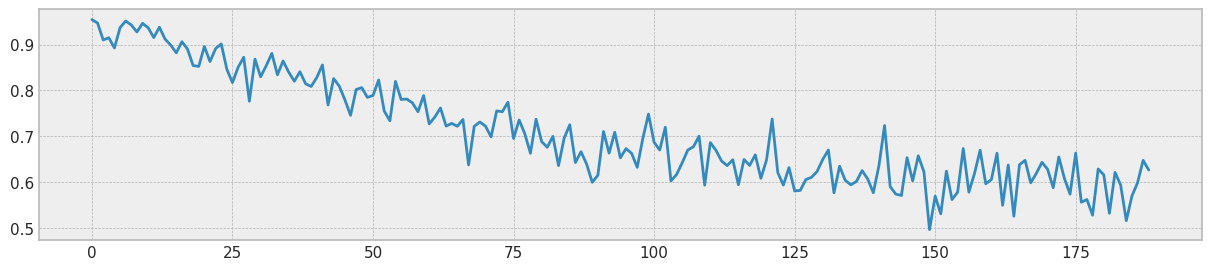

Mean F1 for all data: 0.7089384353863452
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [mi loss1: 0.005351] [mi loss2: 0.005623] [A loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss1: -0.000155] [mi loss2: -0.000113] [A loss: 0.003513] [G loss: 0.636991]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss1: 0.000033] [mi loss2: -0.000907] [A loss: 0.002197] [G loss: 0.590826]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss1: -0.001170] [mi loss2: -0.000014] [A loss: 0.004195] [G loss: 0.537706]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss1: -0.002958] [mi loss2: 0.001626] [A loss: 0.006115] [G loss: 0.482892]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss1: -0.002418] [mi loss2: -0.001214] [A loss: 0.007253] [G loss: 0.433605]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss1: -0.007224] [mi loss2: 0.002200] [A loss: 0.007647] [G loss: 0.392693]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss1: -0.005884] [mi loss2: -0.000428] [A loss: 0.008388] [G loss: 0.357006]
[Lambda: 0.1

100%|██████████| 189/189 [00:00<00:00, 336.32it/s]


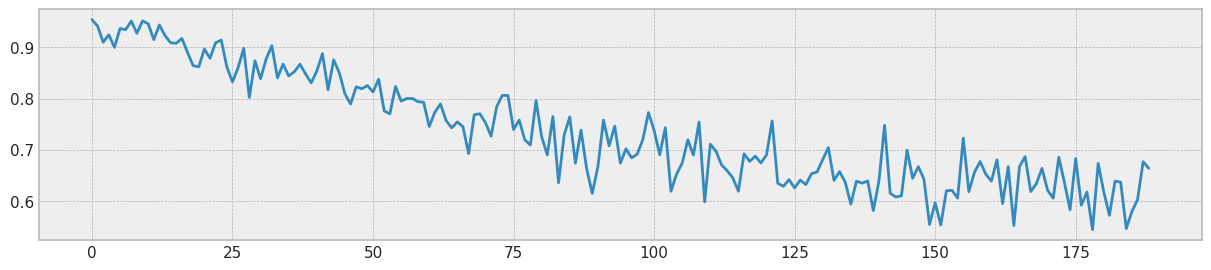

Mean F1 for all data: 0.7343095639402802
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [mi loss1: 0.005351] [mi loss2: 0.005623] [A loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss1: -0.000168] [mi loss2: -0.000080] [A loss: 0.003513] [G loss: 0.636984]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss1: 0.000186] [mi loss2: -0.000949] [A loss: 0.002198] [G loss: 0.590819]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss1: -0.001164] [mi loss2: -0.000034] [A loss: 0.004189] [G loss: 0.537693]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss1: -0.003339] [mi loss2: 0.001486] [A loss: 0.006106] [G loss: 0.482835]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss1: -0.002689] [mi loss2: -0.001236] [A loss: 0.007267] [G loss: 0.433474]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss1: -0.007925] [mi loss2: 0.002324] [A loss: 0.007691] [G loss: 0.392441]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss1: -0.006108] [mi loss2: 0.000237] [A loss: 0.008485] [G loss: 0.356515]
[Lambda: 0.20

100%|██████████| 189/189 [00:00<00:00, 319.34it/s]


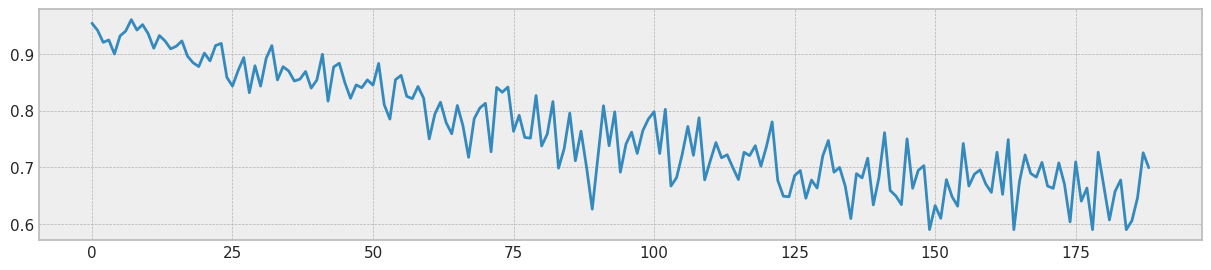

Mean F1 for all data: 0.7642933991762179
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [mi loss1: 0.005351] [mi loss2: 0.005623] [A loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss1: -0.000166] [mi loss2: -0.000093] [A loss: 0.003513] [G loss: 0.636990]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss1: 0.000116] [mi loss2: -0.001014] [A loss: 0.002201] [G loss: 0.590820]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss1: -0.001218] [mi loss2: -0.000069] [A loss: 0.004179] [G loss: 0.537714]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss1: -0.003554] [mi loss2: 0.001827] [A loss: 0.006099] [G loss: 0.482804]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss1: -0.002570] [mi loss2: -0.001260] [A loss: 0.007272] [G loss: 0.433366]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss1: -0.008399] [mi loss2: 0.002256] [A loss: 0.007754] [G loss: 0.392151]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss1: -0.006563] [mi loss2: 0.000070] [A loss: 0.008738] [G loss: 0.355826]
[Lambda: 0.30

100%|██████████| 189/189 [00:00<00:00, 335.94it/s]


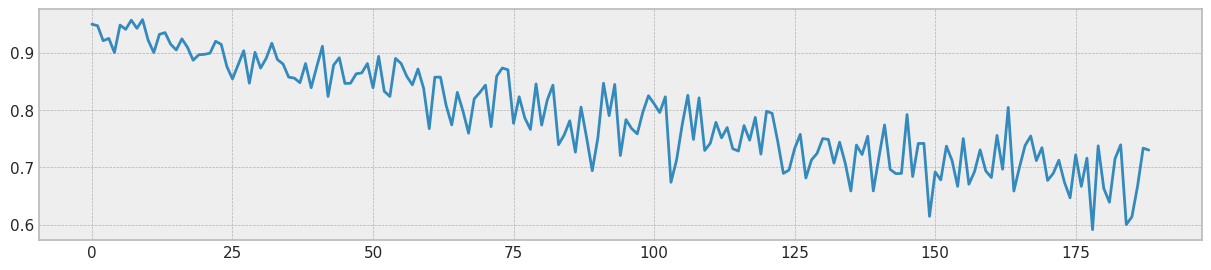

Mean F1 for all data: 0.79021729697197
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [mi loss1: 0.005351] [mi loss2: 0.005623] [A loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss1: -0.000162] [mi loss2: -0.000107] [A loss: 0.003513] [G loss: 0.636988]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss1: 0.000152] [mi loss2: -0.001013] [A loss: 0.002203] [G loss: 0.590824]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss1: -0.001369] [mi loss2: -0.000015] [A loss: 0.004186] [G loss: 0.537745]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss1: -0.003988] [mi loss2: 0.001717] [A loss: 0.006074] [G loss: 0.482879]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss1: -0.003230] [mi loss2: -0.001621] [A loss: 0.007294] [G loss: 0.433337]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss1: -0.009702] [mi loss2: 0.002239] [A loss: 0.007910] [G loss: 0.391862]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss1: -0.007554] [mi loss2: 0.000161] [A loss: 0.009168] [G loss: 0.355044]
[Lambda: 0.4000

100%|██████████| 189/189 [00:00<00:00, 347.64it/s]


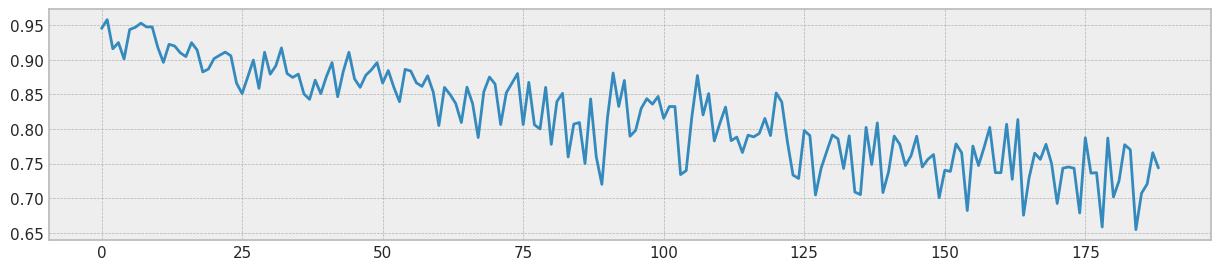

Mean F1 for all data: 0.8175487818546926
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [mi loss1: 0.005351] [mi loss2: 0.005623] [A loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss1: -0.000172] [mi loss2: -0.000075] [A loss: 0.003514] [G loss: 0.636939]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss1: 0.000201] [mi loss2: -0.001134] [A loss: 0.002206] [G loss: 0.590785]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss1: -0.001526] [mi loss2: -0.000073] [A loss: 0.004191] [G loss: 0.537835]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss1: -0.005223] [mi loss2: 0.002417] [A loss: 0.006008] [G loss: 0.483199]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss1: -0.003811] [mi loss2: -0.001936] [A loss: 0.007348] [G loss: 0.433525]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss1: -0.011550] [mi loss2: 0.002827] [A loss: 0.008323] [G loss: 0.391499]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss1: -0.008914] [mi loss2: 0.000165] [A loss: 0.009561] [G loss: 0.354433]
[Lambda: 0.50

100%|██████████| 189/189 [00:00<00:00, 332.20it/s]


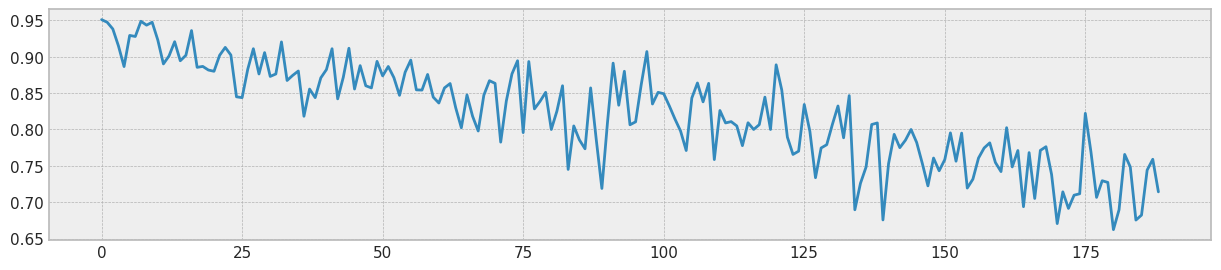

Mean F1 for all data: 0.8210093092983025
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [mi loss1: 0.005351] [mi loss2: 0.005623] [A loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss1: -0.000164] [mi loss2: -0.000075] [A loss: 0.003514] [G loss: 0.636894]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss1: -0.000038] [mi loss2: -0.001007] [A loss: 0.002207] [G loss: 0.590769]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss1: -0.001698] [mi loss2: -0.000117] [A loss: 0.004193] [G loss: 0.538002]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss1: -0.007065] [mi loss2: 0.003298] [A loss: 0.006076] [G loss: 0.483669]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss1: -0.005269] [mi loss2: -0.003156] [A loss: 0.007548] [G loss: 0.434041]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss1: -0.016746] [mi loss2: 0.003926] [A loss: 0.008899] [G loss: 0.391676]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss1: -0.013311] [mi loss2: -0.000496] [A loss: 0.010821] [G loss: 0.354038]
[Lambda: 0.

100%|██████████| 189/189 [00:00<00:00, 328.29it/s]


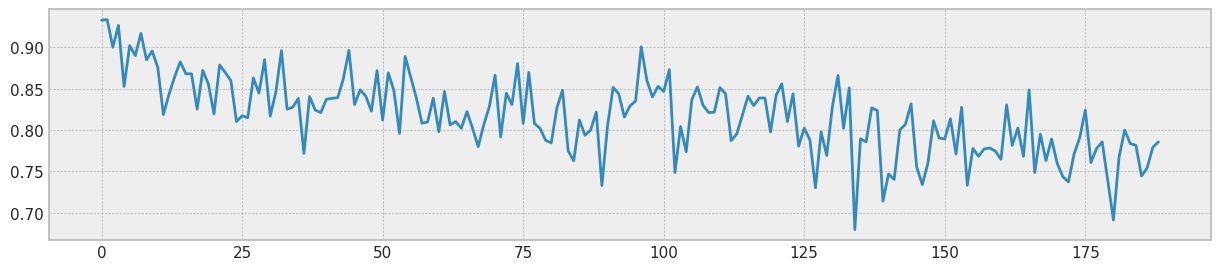

Mean F1 for all data: 0.8175167237429208
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [mi loss1: 0.005351] [mi loss2: 0.005623] [A loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss1: -0.000143] [mi loss2: -0.000082] [A loss: 0.003517] [G loss: 0.636846]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss1: 0.000090] [mi loss2: -0.001209] [A loss: 0.002210] [G loss: 0.590859]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss1: -0.002163] [mi loss2: -0.000045] [A loss: 0.004190] [G loss: 0.538783]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss1: -0.012017] [mi loss2: 0.005298] [A loss: 0.006580] [G loss: 0.485797]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss1: -0.011211] [mi loss2: -0.006766] [A loss: 0.008598] [G loss: 0.437369]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss1: -0.032952] [mi loss2: 0.006362] [A loss: 0.010537] [G loss: 0.396028]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss1: -0.024451] [mi loss2: -0.001835] [A loss: 0.012919] [G loss: 0.361488]
[Lambda: 0.7

100%|██████████| 189/189 [00:00<00:00, 333.22it/s]


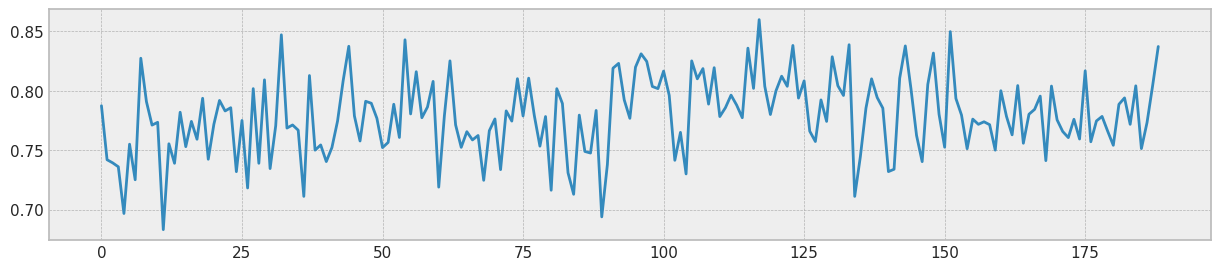

Mean F1 for all data: 0.7783779899075115
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [mi loss1: 0.005351] [mi loss2: 0.005623] [A loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss1: -0.000134] [mi loss2: -0.000085] [A loss: 0.003522] [G loss: 0.636833]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss1: -0.000009] [mi loss2: -0.001294] [A loss: 0.002244] [G loss: 0.591190]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss1: -0.002997] [mi loss2: -0.000421] [A loss: 0.004220] [G loss: 0.541081]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss1: -0.019973] [mi loss2: 0.006370] [A loss: 0.007159] [G loss: 0.492639]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss1: -0.023801] [mi loss2: -0.013652] [A loss: 0.013056] [G loss: 0.449053]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss1: -0.056540] [mi loss2: 0.009188] [A loss: 0.015501] [G loss: 0.415156]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss1: -0.045127] [mi loss2: -0.008905] [A loss: 0.017777] [G loss: 0.393213]
[Lambda: 0.

100%|██████████| 189/189 [00:00<00:00, 334.95it/s]


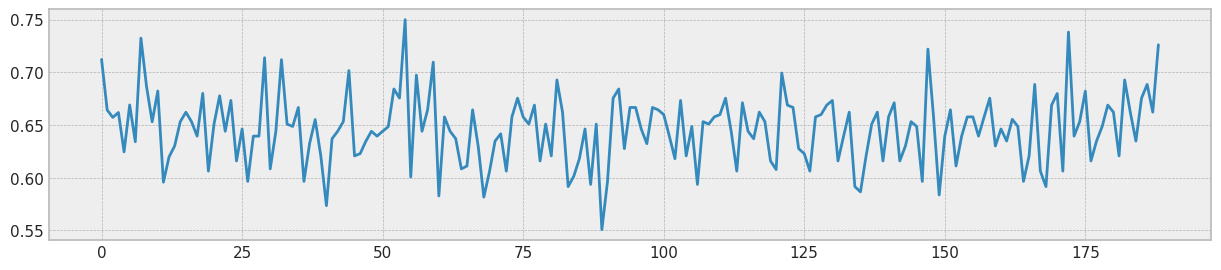

Mean F1 for all data: 0.646166091783441
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [mi loss1: 0.005351] [mi loss2: 0.005623] [A loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss1: -0.000115] [mi loss2: -0.000136] [A loss: 0.003540] [G loss: 0.637065]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss1: -0.000300] [mi loss2: -0.001619] [A loss: 0.002463] [G loss: 0.592950]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss1: -0.005186] [mi loss2: -0.001721] [A loss: 0.004865] [G loss: 0.548557]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss1: -0.033466] [mi loss2: 0.005650] [A loss: 0.012388] [G loss: 0.509335]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss1: -0.049050] [mi loss2: -0.025703] [A loss: 0.021763] [G loss: 0.481665]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss1: -0.103779] [mi loss2: 0.003788] [A loss: 0.032383] [G loss: 0.461645]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss1: -0.099947] [mi loss2: -0.020053] [A loss: 0.045303] [G loss: 0.456362]
[Lambda: 0.9

100%|██████████| 189/189 [00:00<00:00, 323.37it/s]


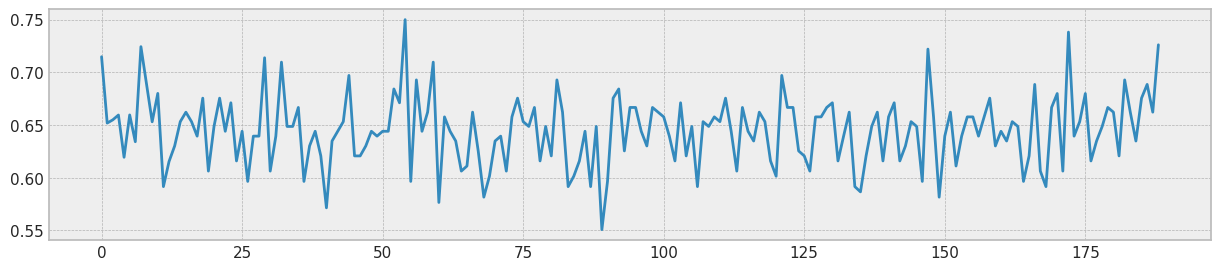

Mean F1 for all data: 0.6449275662789752


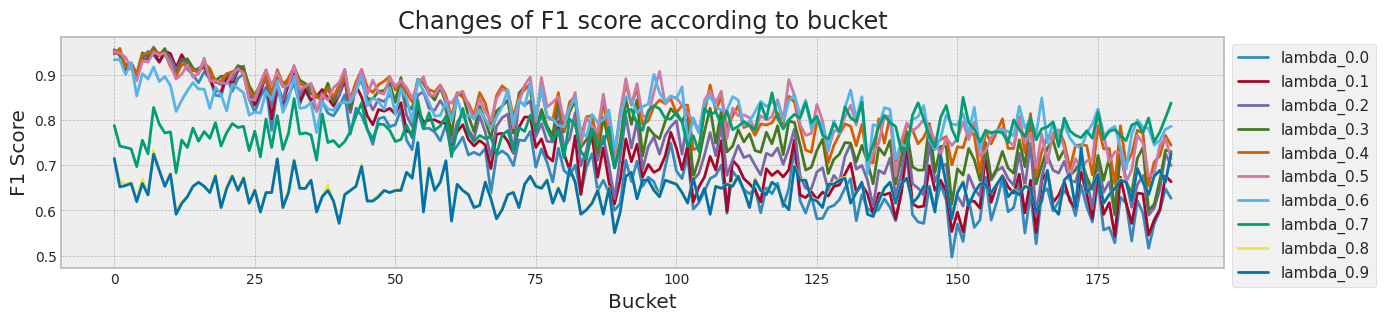

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.002514
1  Case #2 Feature 5  0.875000  0.987952  0.877103  0.752137  0.012903
2  Case #3 Feature 5  0.969697  0.939394  0.731917  0.648148  0.000000
3  Case #3 Feature 4  0.969697  0.864583  0.857218  0.871560  0.000000
0                0.0  0.958084  0.954315  0.708938  0.626728  0.105645
1                0.1  0.946108  0.954315  0.734310  0.663462  0.102946
2                0.2  0.946108  0.954315  0.764293  0.699029  0.102946
3                0.3  0.952381  0.949495  0.790217  0.730000  0.103701
4                0.4  0.952941  0.945274  0.817549  0.743719  0.124244
5                0.5  0.936416  0.950980  0.821009  0.714286  0.102452
6                0.6  0.926554  0.932692  0.817517  0.785714  0.095107
7                0.7  0.694561  0.787402  0.778378  0.837209  0.172893
8                0.8  0.630350  0.712230  0.646166  0.726115  0.340775
9                0.9  0.625000  0.714801  0.644928  0.726115  0.391312

In [54]:
#train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.

lambda_f_set2 = [1.0] #[0.391] 

for lambda_f2 in lambda_f_set2:
    
    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:

        f1,mi,last_generator, last_adapter = train_model3(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=lambda_f2)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter, X2[2000:][['x0','x1','x2','x3','z0','b']], y2[2000:])

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3),title='Changes of F1 score according to bucket',ylabel='F1 Score',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    result4_df = pd.DataFrame(result_table2)

pd.concat([pd.DataFrame(result_table3),result4_df])

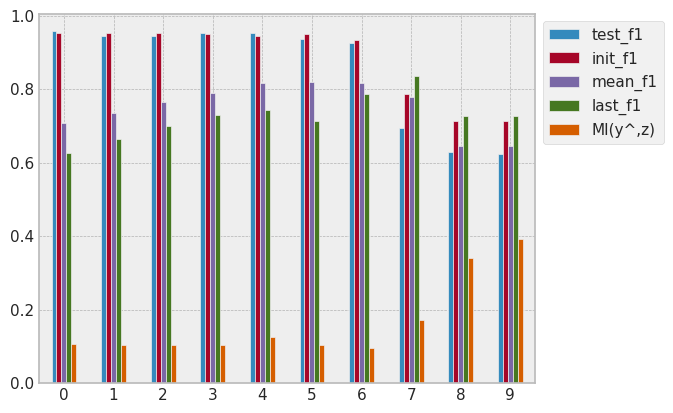

In [55]:
result4_df[['test_f1','init_f1','mean_f1','last_f1','MI(y^,z)']].plot.bar(rot=0)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

# Case #4 (Case #1,2,3의 상황이 각 feature에 혼재되어 있는 경우)

In [56]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = np.random.normal(1,cor_,data_size)

y_array = []
cor_const = cor[4] 
cor_const2 = 3/x.shape[0]
for ii in range(x.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 고정, Drift의 증가 - x3
    e1 = np.random.normal(0.0, cor_const2 * ii)
    x[ii,3] = x[ii,3] + e1
    y_array.append(np.sum(cor * x[ii])+e)

y = [1 if y_ > 5 else 0 for y_ in y1_array]

#Case #1 MI의 감소, Drift의 증가 - x2
for i in range(400):
    s = i*100
    x[s:s+100,2] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)

In [57]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x0    0.227465
z0    0.088169
x2    0.024896
x1    0.018550
x3    0.000000
Name: MI Scores, dtype: float64


Bucket size 50


100%|██████████| 50/50 [00:01<00:00, 45.77it/s]


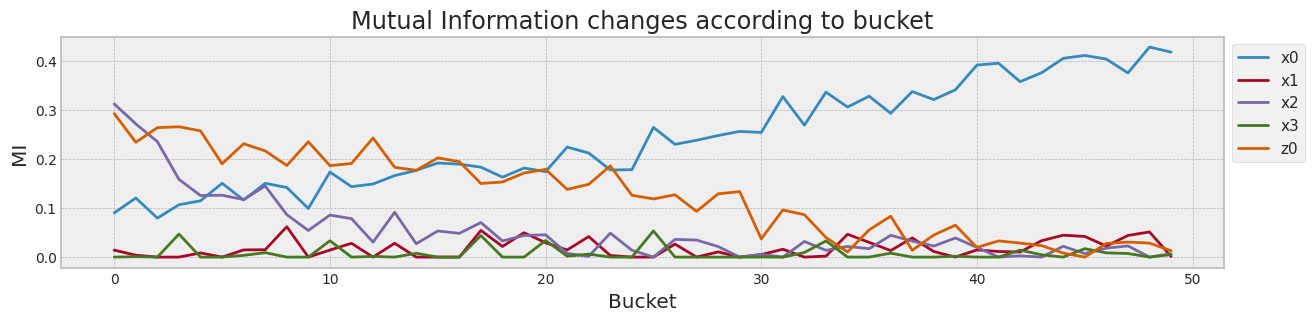

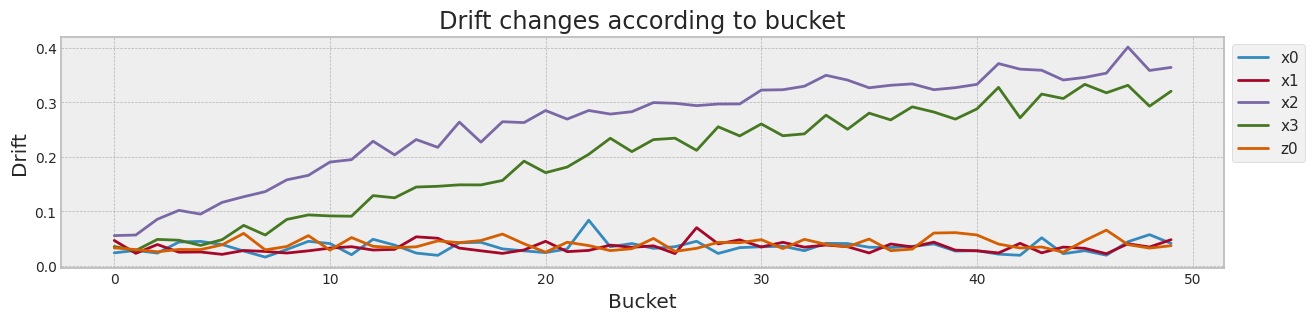

In [58]:
from tqdm import tqdm

bucket_size_array=[50]#[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((x.shape[0]-2000)/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*step_size:bk*step_size+step_size], y[bk*step_size:bk*step_size+step_size], discrete_features="auto")
        ks = __ks_drift(X[0:1800].values,X[bk*step_size+2000:bk*step_size+step_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col]) 
            DRF[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    df_mis.plot(figsize=(15,3),title='Mutual Information changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    df_drf.plot(figsize=(15,3),title='Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

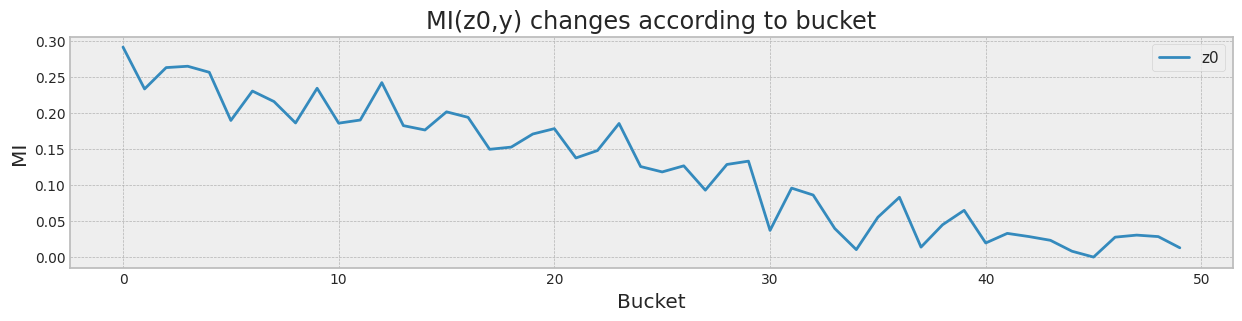

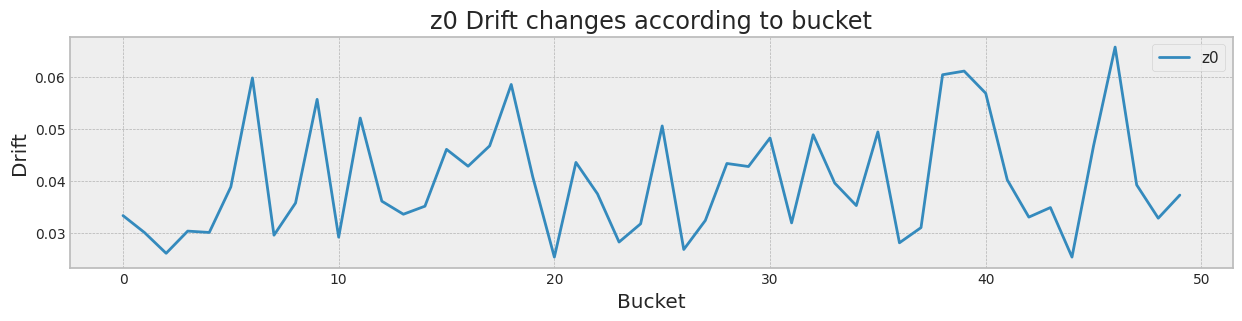

In [59]:
# Case #2, MI의 증감(상대적), Drift의 고정 - z0
df_mis['z0'].plot(figsize=(15,3),title='MI(z0,y) changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()
df_drf['z0'].plot(figsize=(15,3),title='z0 Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

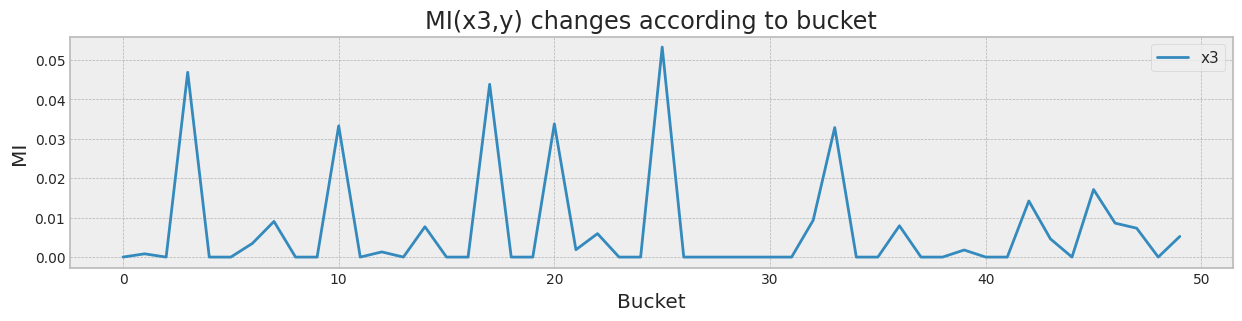

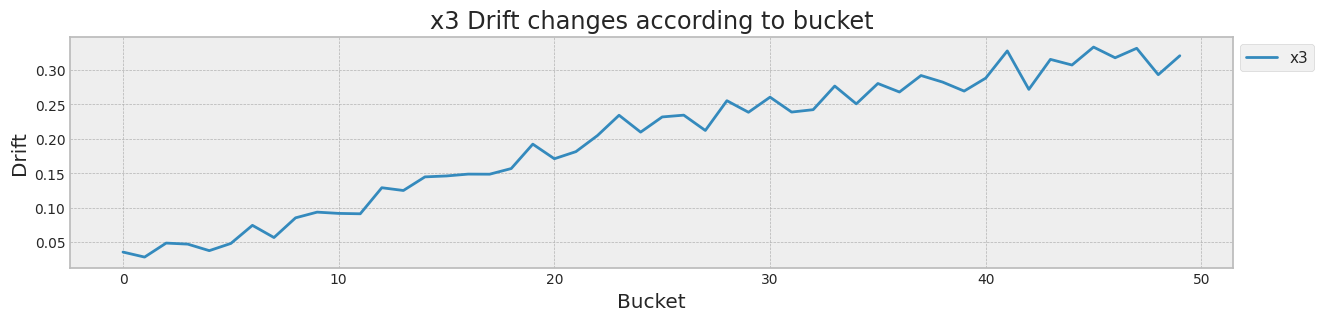

In [60]:
# Case #3 MI의 고정, Drift의 증가 - x3
df_mis['x3'].plot(figsize=(15,3),title='MI(x3,y) changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()
df_drf['x3'].plot(figsize=(15,3),title='x3 Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

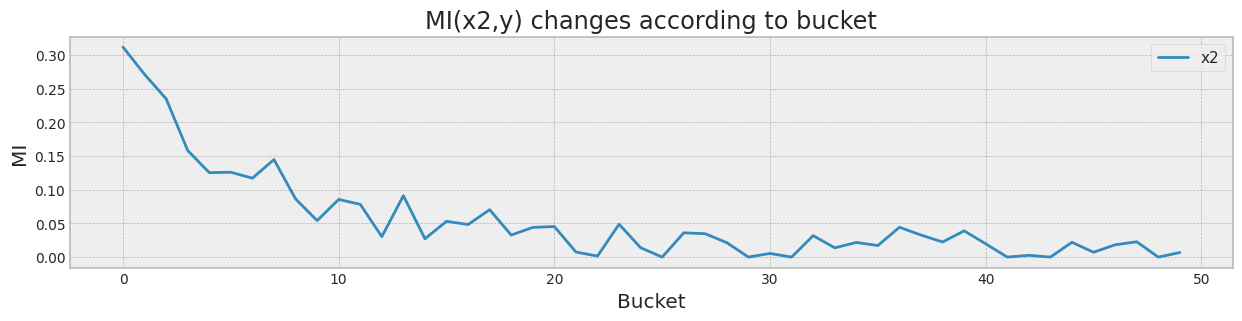

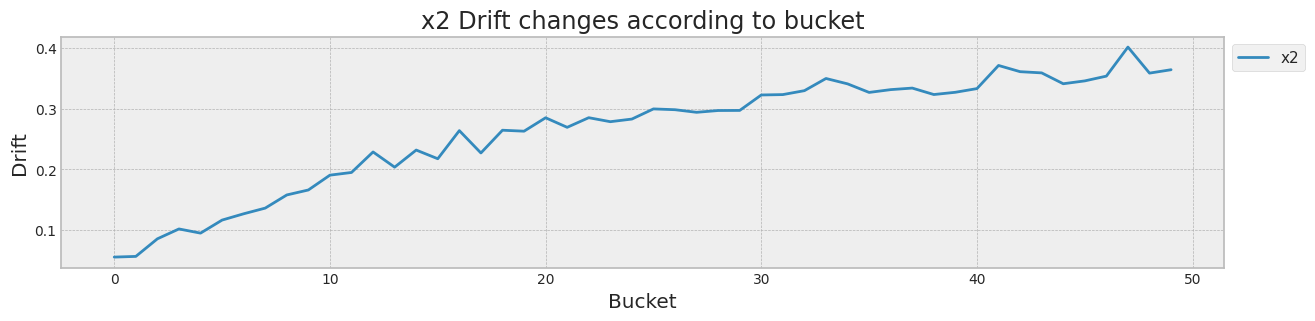

In [61]:
#Case #1 MI의 감소, Drift의 증가 - x2
df_mis['x2'].plot(figsize=(15,3),title='MI(x2,y) changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()
df_drf['x2'].plot(figsize=(15,3),title='x2 Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

## Case #4의 학습

cuda:0


100%|██████████| 1000/1000 [00:24<00:00, 40.53it/s]


MSE: 0.06
RMSE: 0.25


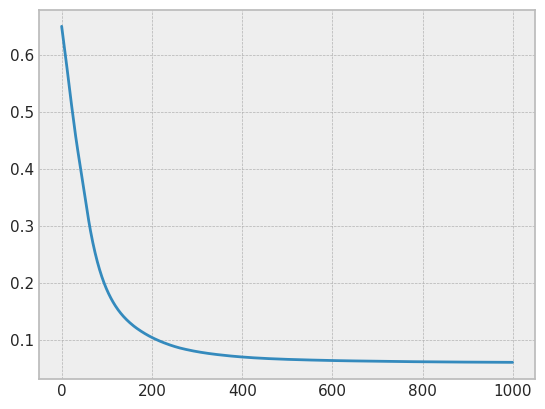

In [62]:
import copy
import torch.optim as optim
 
seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [63]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

feature 5, test_f1 0.9732142857142857


100%|██████████| 189/189 [00:00<00:00, 516.21it/s]


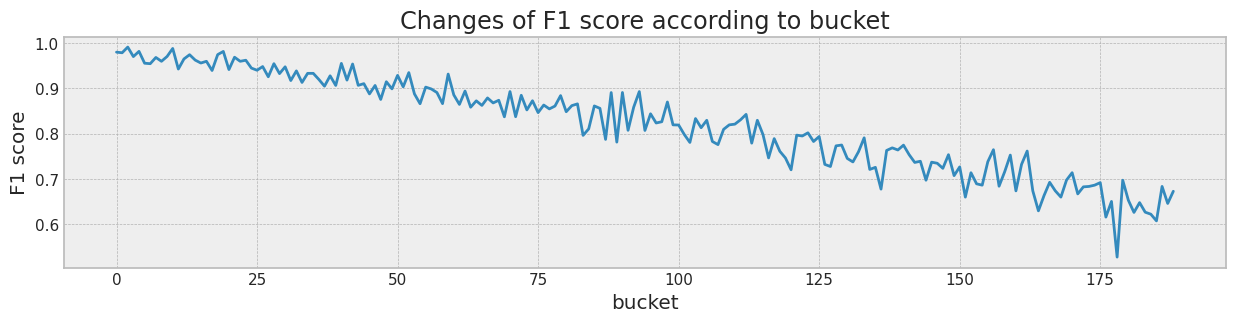

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.002514
1  Case #2 Feature 5  0.875000  0.987952  0.877103  0.752137  0.012903
2  Case #3 Feature 5  0.969697  0.939394  0.731917  0.648148  0.000000
3  Case #3 Feature 4  0.969697  0.864583  0.857218  0.871560  0.000000
4  Case #4 Feature 5  0.973214  0.980237  0.821443  0.672489  0.006732

In [64]:
XT = X[2000:][['x0','x1','x2','x3','z0']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.ylabel('F1 score')
    plt.xlabel('bucket')
    plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3['lambda'].append('Case #4 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['x2'])

pd.DataFrame(result_table3)

cuda:0


100%|██████████| 1000/1000 [00:26<00:00, 37.29it/s]


MSE: 0.08
RMSE: 0.28


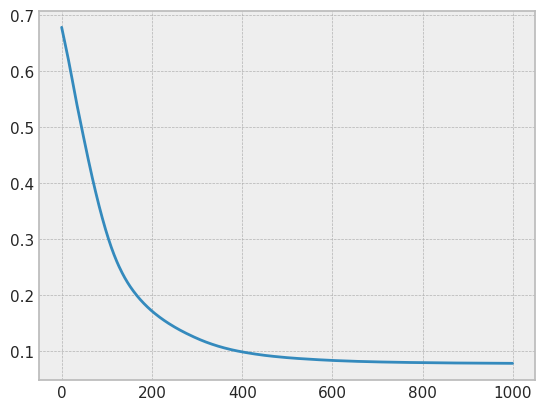

In [74]:
import copy
import torch.optim as optim
 
seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X[1800:2000][['x0','x1','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)
 
# Define the model
model = nn.Sequential(
    nn.Linear(4, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [76]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 4, test_f1',f1)

feature 4, test_f1 0.9652173913043478


100%|██████████| 189/189 [00:00<00:00, 444.79it/s]


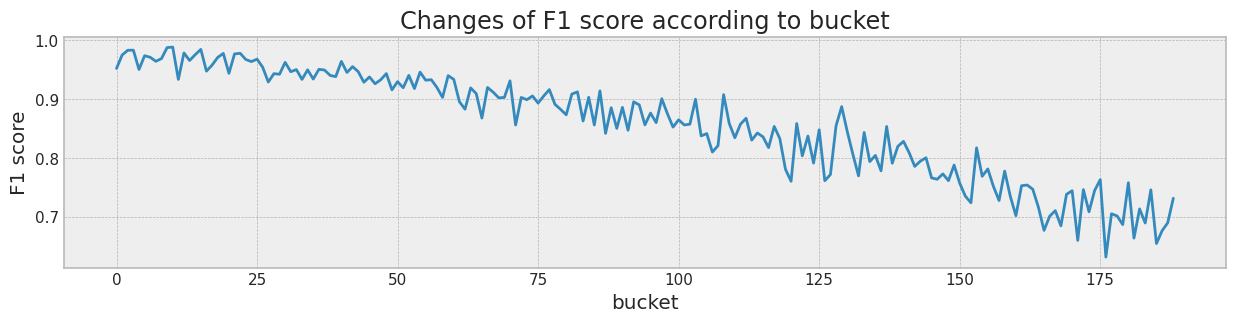

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.002514
1  Case #2 Feature 5  0.875000  0.987952  0.877103  0.752137  0.012903
2  Case #3 Feature 5  0.969697  0.939394  0.731917  0.648148  0.000000
3  Case #3 Feature 4  0.969697  0.864583  0.857218  0.871560  0.000000
4  Case #4 Feature 5  0.973214  0.980237  0.821443  0.672489  0.006732
5  Case #4 Feature 4  0.965217  0.952000  0.856297  0.731092  0.006732

In [77]:
XT = X[2000:][['x0','x1','x3','z0']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.ylabel('F1 score')
    plt.xlabel('bucket')
    plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3['lambda'].append('Case #4 Feature 4')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['x2'])

pd.DataFrame(result_table3)

## 내성학습의 적용!

In [65]:
X['b'] = [int(b) for b in X.index.values]
X

x0        x1         x2        x3        z0      b
0      1.877314  1.185467   0.569114  1.124792 -1.925585      0
1      2.846794  0.461018   1.846127  1.282188  3.281450      1
2      2.232850  0.876278   0.988374  2.019024  0.187403      2
3     -0.198843  2.579531   2.045837  1.019120  2.385340      3
4      1.618080  1.683218   1.924591  0.696970  0.195648      4
...         ...       ...        ...       ...       ...    ...
39995 -0.321489  0.268097  -5.328180  1.865373  4.096949  39995
39996 -0.037401  1.055617  -3.625696  0.332384  3.850920  39996
39997  2.262545 -0.256564   4.910739  5.040302  0.498200  39997
39998  0.823467  1.489013   8.341265  1.477920  5.022454  39998
39999  2.024101  2.498025  11.309512  6.730665  0.816579  39999

[40000 rows x 6 columns]

In [69]:

def train_model4(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):

    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    s1_train = train_tensors.s1_train.to(device)
    
    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    s1_test = test_tensors.s1_test.to(device)
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    a_losses =[]
    g_losses =[]
    mi_losses1 = []
    mi_losses2 = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator().to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net().to(device)
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 500

    for epoch in range(n_epochs):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------
        xs = adapter(XS_train[:,0:5],XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
        a_loss = torch.sum(mse_loss(xs, XS_train[:,0:5]))
        a_losses.append(a_loss)
        # -------------------
        #  Forwards Generator
        # -------------------
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        # -------------------------------
        #  MINE
        # -------------------------------
        #Sample을 앞 뒤 반으로 나눈다.
        sa = np.random.choice(range(0,int(XS_train.shape[0]/2)),minibatch)
        sb = np.random.choice(range(int(XS_train.shape[0]/2),XS_train.shape[0]),minibatch)
        
        # Case #3에 해당하는, MI변화 없이, Drift만 변하는 feature는 x3 이다.
        x_sample = Variable(torch.clone(XS_train[sa,2].detach().reshape(-1,1)) , requires_grad = True).to(device)
        y_sample = gen_y[sa] # y_train[s].reshape(-1,1) #gen_y0[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = gen_y[np.random.permutation(sa)] #y_train[np.random.permutation(s)].reshape(-1,1) # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)    
        
        x2_sample = Variable(torch.clone(XS_train[sb,2].detach().reshape(-1,1)) , requires_grad = True).to(device)
        y2_sample = gen_y[sb]
        y2_shuffle = gen_y[np.random.permutation(sb)] #Variable(torch.from_numpy(np.random.permutation(y2)).type(torch.FloatTensor), requires_grad = True)    

        ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        ret2 = torch.mean(mine(x2_sample, y2_sample)) - torch.log(torch.mean(torch.exp(mine(x2_sample, y2_shuffle))))

        # ret1(bucket 앞부분의 Sample에 대한 MI)는 maximize 하야 하고
        # ret2(bucket 뒷부분의 Sample에 대한 MI)는 0으로 minimize 해야 한다.!!! => 즉, bucket의 증가, 시간이 지난수록 MI를 낮추는 방향으로 학습을 진행 하는 것!
        mi_loss = - ret1 + torch.abs(ret2)
        mi_losses1.append(-ret1)
        mi_losses2.append(-ret2)


        optimizer_A.zero_grad()
        optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        loss = (1-lambda_f) * (g_loss + a_loss) + lambda_f * mi_loss * alpha

        loss.backward()
        optimizer_G.step()
        optimizer_M.step()
        optimizer_A.step()            

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss1: %f] [mi loss2: %f] [A loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses1[-1], mi_losses2[-1], a_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator,adapter

lambda_f2 0.07
cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [mi loss1: 0.014217] [mi loss2: 0.016601] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss1: 0.017602] [mi loss2: 0.019141] [A loss: 0.006962] [G loss: 0.580296]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss1: 0.022640] [mi loss2: 0.022650] [A loss: 0.003029] [G loss: 0.497959]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss1: 0.022296] [mi loss2: 0.025630] [A loss: 0.003171] [G loss: 0.421087]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss1: 0.028107] [mi loss2: 0.028852] [A loss: 0.004157] [G loss: 0.343848]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss1: 0.033009] [mi loss2: 0.035307] [A loss: 0.004805] [G loss: 0.280328]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss1: 0.033131] [mi loss2: 0.032913] [A loss: 0.005174] [G loss: 0.231553]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss1: 0.034352] [mi loss2: 0.037594] [A loss: 0.005425] [G loss: 0.194728]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss1: 0

100%|██████████| 189/189 [00:00<00:00, 310.68it/s]


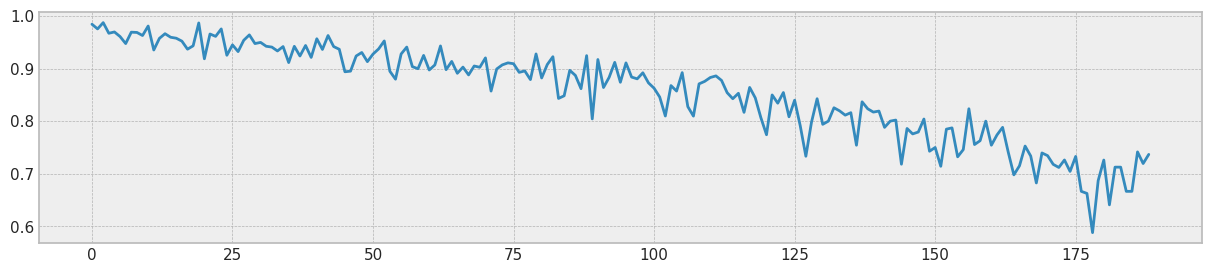

Mean F1 for all data: 0.8553831973884488
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [mi loss1: 0.014217] [mi loss2: 0.016601] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss1: -0.000588] [mi loss2: 0.000224] [A loss: 0.006962] [G loss: 0.580292]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss1: -0.006253] [mi loss2: -0.004284] [A loss: 0.003029] [G loss: 0.497950]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss1: -0.025541] [mi loss2: -0.025465] [A loss: 0.003172] [G loss: 0.421062]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss1: -0.096226] [mi loss2: -0.021364] [A loss: 0.004159] [G loss: 0.343803]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss1: -0.126222] [mi loss2: 0.009736] [A loss: 0.004816] [G loss: 0.280268]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss1: -0.176813] [mi loss2: -0.118463] [A loss: 0.005192] [G loss: 0.231485]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss1: -0.181661] [mi loss2: -0.199099] [A loss: 0.005431] [G loss: 0.194676]
[Lambda: 0.

100%|██████████| 189/189 [00:00<00:00, 330.62it/s]


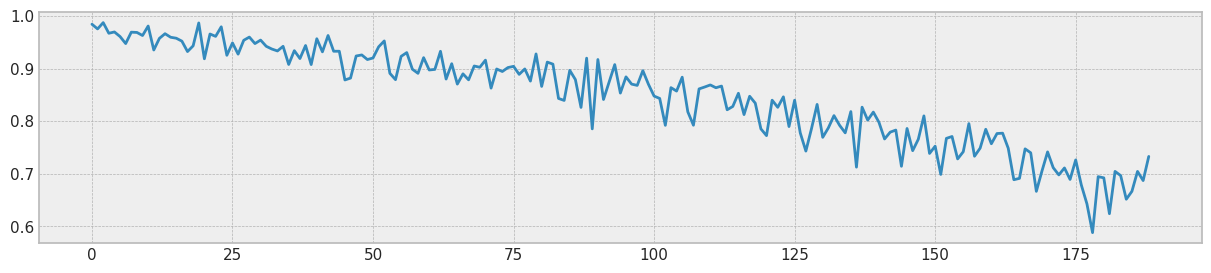

Mean F1 for all data: 0.84743115610632
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [mi loss1: 0.014217] [mi loss2: 0.016601] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss1: -0.000696] [mi loss2: 0.000141] [A loss: 0.006962] [G loss: 0.580285]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss1: -0.008222] [mi loss2: -0.006099] [A loss: 0.003030] [G loss: 0.497937]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss1: -0.031677] [mi loss2: -0.033074] [A loss: 0.003176] [G loss: 0.421031]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss1: -0.091006] [mi loss2: -0.006501] [A loss: 0.004166] [G loss: 0.343748]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss1: -0.112327] [mi loss2: 0.046478] [A loss: 0.004825] [G loss: 0.280204]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss1: -0.170143] [mi loss2: -0.106131] [A loss: 0.005199] [G loss: 0.231426]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss1: -0.180511] [mi loss2: -0.194079] [A loss: 0.005443] [G loss: 0.194618]
[Lambda: 0.20

100%|██████████| 189/189 [00:00<00:00, 324.64it/s]


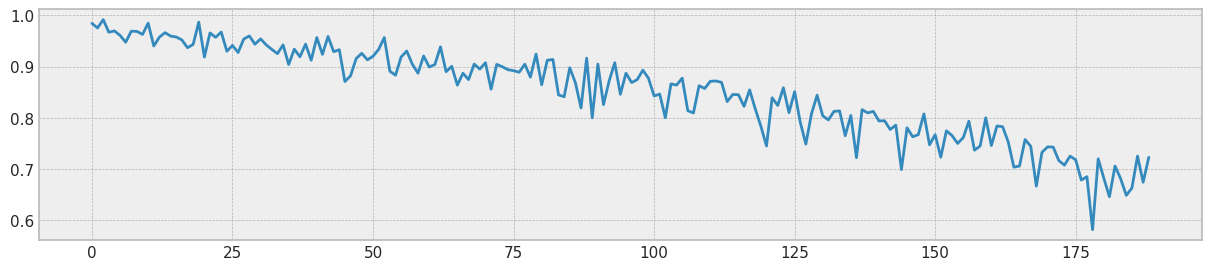

Mean F1 for all data: 0.8494410144453926
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [mi loss1: 0.014217] [mi loss2: 0.016601] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss1: -0.000703] [mi loss2: 0.000118] [A loss: 0.006962] [G loss: 0.580278]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss1: -0.002677] [mi loss2: 0.000018] [A loss: 0.003030] [G loss: 0.497922]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss1: -0.027341] [mi loss2: -0.028281] [A loss: 0.003178] [G loss: 0.420997]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss1: -0.097958] [mi loss2: -0.021396] [A loss: 0.004171] [G loss: 0.343683]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss1: -0.126287] [mi loss2: 0.022703] [A loss: 0.004851] [G loss: 0.280101]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss1: -0.171646] [mi loss2: -0.106877] [A loss: 0.005216] [G loss: 0.231325]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss1: -0.183628] [mi loss2: -0.200703] [A loss: 0.005502] [G loss: 0.194487]
[Lambda: 0.3

100%|██████████| 189/189 [00:00<00:00, 307.39it/s]


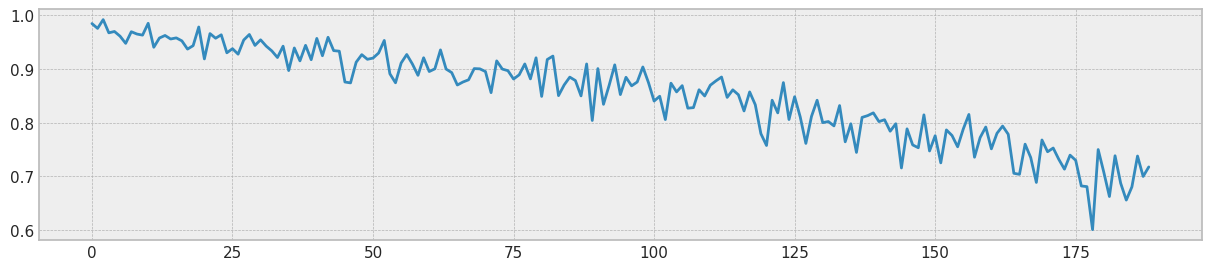

Mean F1 for all data: 0.852985824210247
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [mi loss1: 0.014217] [mi loss2: 0.016601] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss1: -0.000655] [mi loss2: 0.000185] [A loss: 0.006962] [G loss: 0.580268]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss1: -0.006928] [mi loss2: -0.004475] [A loss: 0.003031] [G loss: 0.497896]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss1: -0.015701] [mi loss2: -0.014279] [A loss: 0.003174] [G loss: 0.420967]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss1: -0.092049] [mi loss2: -0.006420] [A loss: 0.004177] [G loss: 0.343605]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss1: -0.115775] [mi loss2: 0.052295] [A loss: 0.004867] [G loss: 0.279982]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss1: -0.182469] [mi loss2: -0.124766] [A loss: 0.005285] [G loss: 0.231156]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss1: -0.182101] [mi loss2: -0.197065] [A loss: 0.005559] [G loss: 0.194358]
[Lambda: 0.4

100%|██████████| 189/189 [00:00<00:00, 322.33it/s]


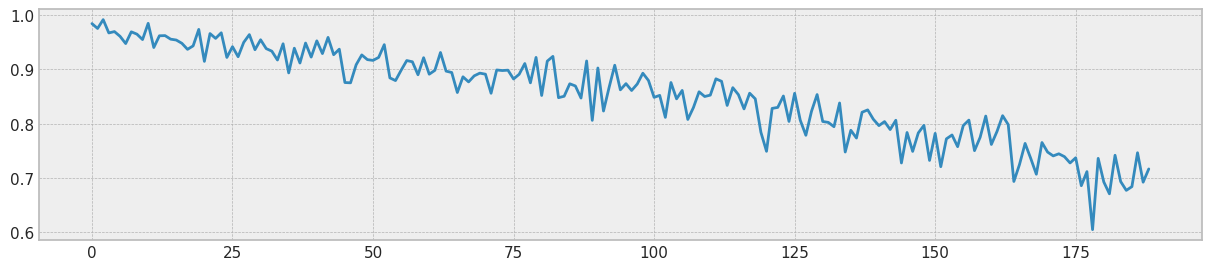

Mean F1 for all data: 0.8528574547613588
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [mi loss1: 0.014217] [mi loss2: 0.016601] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss1: -0.000720] [mi loss2: 0.000107] [A loss: 0.006962] [G loss: 0.580254]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss1: -0.007244] [mi loss2: -0.005027] [A loss: 0.003032] [G loss: 0.497869]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss1: -0.028935] [mi loss2: -0.029905] [A loss: 0.003190] [G loss: 0.420890]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss1: -0.086057] [mi loss2: -0.002896] [A loss: 0.004183] [G loss: 0.343505]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss1: -0.127187] [mi loss2: 0.018494] [A loss: 0.004928] [G loss: 0.279795]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss1: -0.175497] [mi loss2: -0.113808] [A loss: 0.005360] [G loss: 0.230964]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss1: -0.185297] [mi loss2: -0.202831] [A loss: 0.005665] [G loss: 0.194155]
[Lambda: 0.

100%|██████████| 189/189 [00:00<00:00, 333.97it/s]


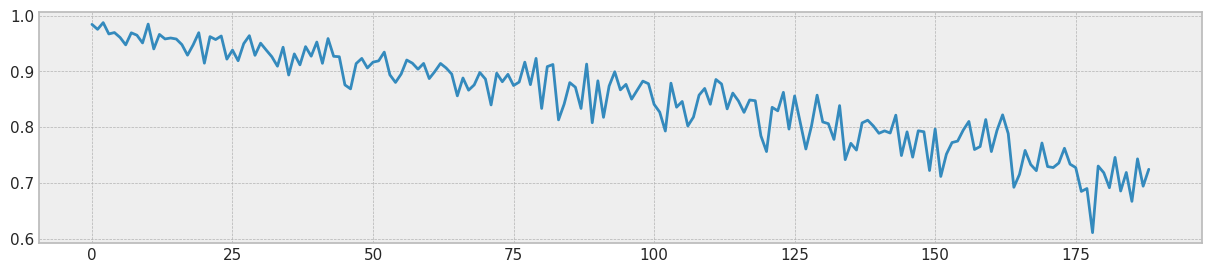

Mean F1 for all data: 0.8504761005741933
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [mi loss1: 0.014217] [mi loss2: 0.016601] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss1: -0.000693] [mi loss2: 0.000159] [A loss: 0.006962] [G loss: 0.580231]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss1: -0.002611] [mi loss2: 0.000823] [A loss: 0.003032] [G loss: 0.497823]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss1: -0.028718] [mi loss2: -0.029914] [A loss: 0.003194] [G loss: 0.420785]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss1: -0.094953] [mi loss2: -0.008142] [A loss: 0.004214] [G loss: 0.343279]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss1: -0.122958] [mi loss2: 0.034901] [A loss: 0.004959] [G loss: 0.279546]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss1: -0.180294] [mi loss2: -0.119069] [A loss: 0.005511] [G loss: 0.230635]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss1: -0.185766] [mi loss2: -0.203275] [A loss: 0.005864] [G loss: 0.193851]
[Lambda: 0.6

100%|██████████| 189/189 [00:00<00:00, 315.82it/s]


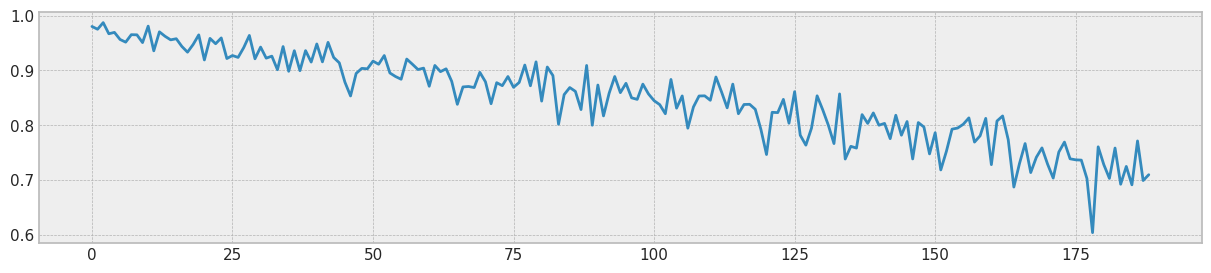

Mean F1 for all data: 0.8495284561337808
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [mi loss1: 0.014217] [mi loss2: 0.016601] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss1: -0.000686] [mi loss2: 0.000165] [A loss: 0.006963] [G loss: 0.580196]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss1: -0.005215] [mi loss2: -0.002475] [A loss: 0.003036] [G loss: 0.497743]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss1: -0.023088] [mi loss2: -0.023125] [A loss: 0.003198] [G loss: 0.420632]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss1: -0.090337] [mi loss2: 0.002783] [A loss: 0.004216] [G loss: 0.343008]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss1: -0.117241] [mi loss2: 0.050183] [A loss: 0.005054] [G loss: 0.279161]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss1: -0.180349] [mi loss2: -0.119796] [A loss: 0.005709] [G loss: 0.230203]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss1: -0.186786] [mi loss2: -0.203061] [A loss: 0.006147] [G loss: 0.193533]
[Lambda: 0.7

100%|██████████| 189/189 [00:00<00:00, 321.41it/s]


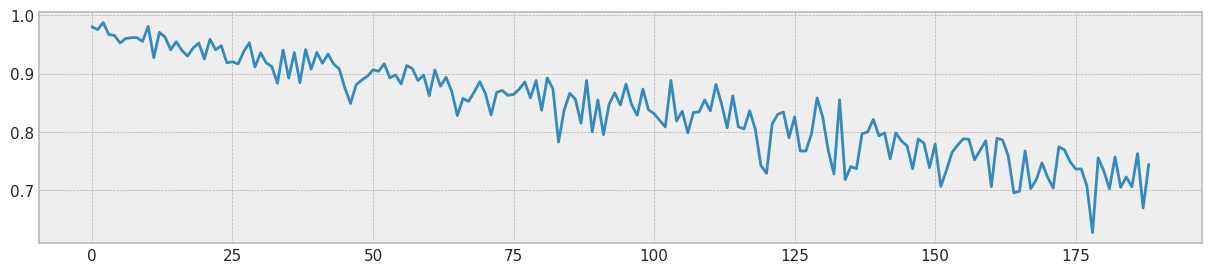

Mean F1 for all data: 0.840435838174678
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [mi loss1: 0.014217] [mi loss2: 0.016601] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss1: -0.000692] [mi loss2: 0.000179] [A loss: 0.006963] [G loss: 0.580123]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss1: -0.006516] [mi loss2: -0.003840] [A loss: 0.003042] [G loss: 0.497585]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss1: -0.023109] [mi loss2: -0.022422] [A loss: 0.003216] [G loss: 0.420272]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss1: -0.100767] [mi loss2: -0.015004] [A loss: 0.004310] [G loss: 0.342317]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss1: -0.129149] [mi loss2: 0.030452] [A loss: 0.005319] [G loss: 0.278341]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss1: -0.182739] [mi loss2: -0.120152] [A loss: 0.006213] [G loss: 0.229423]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss1: -0.191810] [mi loss2: -0.207010] [A loss: 0.006676] [G loss: 0.193187]
[Lambda: 0.8

100%|██████████| 189/189 [00:00<00:00, 328.72it/s]


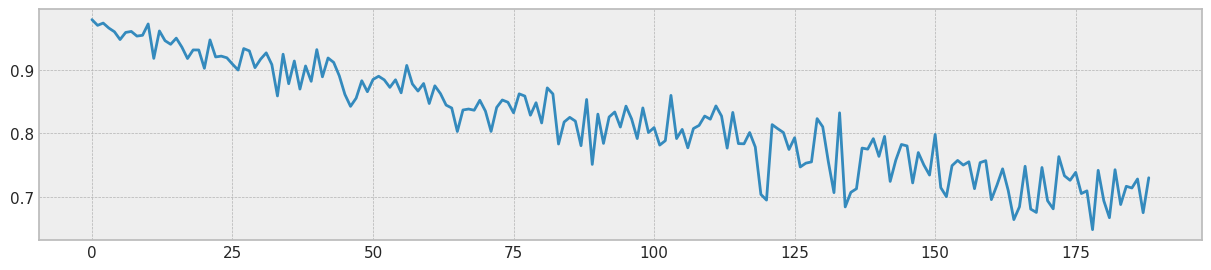

Mean F1 for all data: 0.8203691360484769
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [mi loss1: 0.014217] [mi loss2: 0.016601] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss1: -0.000930] [mi loss2: -0.000105] [A loss: 0.006964] [G loss: 0.579915]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss1: -0.001919] [mi loss2: 0.000902] [A loss: 0.003049] [G loss: 0.497152]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss1: -0.030012] [mi loss2: -0.031355] [A loss: 0.003370] [G loss: 0.419245]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss1: -0.094842] [mi loss2: -0.016033] [A loss: 0.004503] [G loss: 0.340966]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss1: -0.127146] [mi loss2: 0.024299] [A loss: 0.006004] [G loss: 0.276639]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss1: -0.178535] [mi loss2: -0.116828] [A loss: 0.006870] [G loss: 0.228545]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss1: -0.189948] [mi loss2: -0.205822] [A loss: 0.008256] [G loss: 0.192740]
[Lambda: 0.

100%|██████████| 189/189 [00:00<00:00, 306.53it/s]


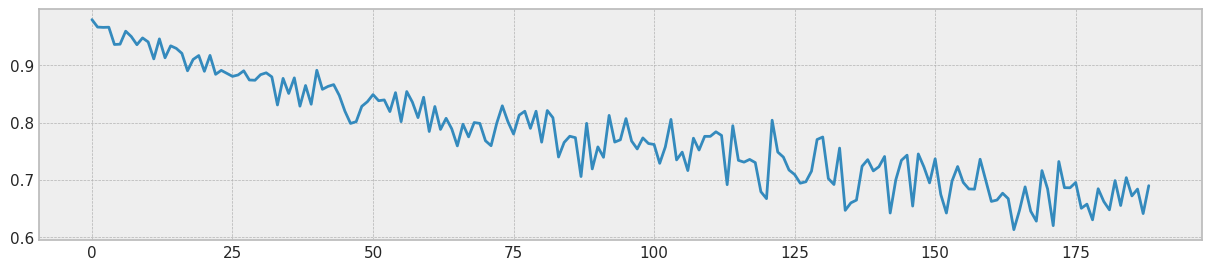

Mean F1 for all data: 0.7780024432282506


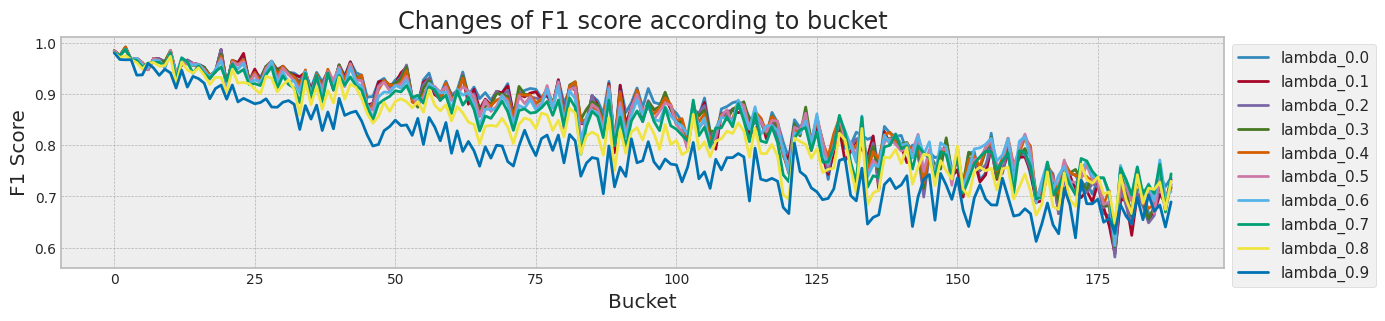

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.002514
1  Case #2 Feature 5  0.875000  0.987952  0.877103  0.752137  0.012903
2  Case #3 Feature 5  0.969697  0.939394  0.731917  0.648148  0.000000
3  Case #3 Feature 4  0.969697  0.864583  0.857218  0.871560  0.000000
4  Case #4 Feature 5  0.973214  0.980237  0.821443  0.672489  0.006732
5  Case #4 Feature 4  0.965217  0.952000  0.856297  0.731092  0.006732
0                0.0  0.965517  0.984127  0.855383  0.736842  0.273702
1                0.1  0.965517  0.984127  0.847431  0.732984  0.273702
2                0.2  0.965517  0.984127  0.849441  0.722772  0.273702
3                0.3  0.965517  0.984127  0.852986  0.717703  0.273702
4                0.4  0.965517  0.984127  0.852857  0.716279  0.273702
5                0.5  0.965517  0.984127  0.850476  0.724138  0.273702
6                0.6  0.965517  0.980237  0.849528  0.709677  0.273702
7                0.7  0.965517  0.980237  0.840436  0.744186  0.273702
8                0.8  0.965517  0.980237  0.820369  0.729927  0.273702
9                0.9  0.957265  0.980237  0.778002  0.689420  0.257201

In [78]:
#train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.

lambda_f_set2 = [0.07] #[0.391] 

for lambda_f2 in lambda_f_set2:
    
    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:

        f1,mi,last_generator, last_adapter = train_model4(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=lambda_f2)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter, X[2000:][['x0','x1','x2','x3','z0','b']], y[2000:])

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3),title='Changes of F1 score according to bucket',ylabel='F1 Score',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    result4_df = pd.DataFrame(result_table2)

pd.concat([pd.DataFrame(result_table3),result4_df])

lambda_f2 1.2
cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 36.594120] [G loss: 0.454781]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 174.192429] [G loss: 0.181764]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 413.751740] [G loss: 0.091353]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 555.097168] [G loss: 0.068831]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 726.206116] [G loss: 0.056415]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 908.638367] [G loss: 0.049722]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 1045.358398] [G loss: 0.046785]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 1133.941772] [G loss: 0.045219]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 1204.624878] [G loss: 0.044155]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 1271.720337] [G loss: 0.043224]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 1325.307373] [G loss: 0.042591]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 1

100%|██████████| 189/189 [00:00<00:00, 334.95it/s]


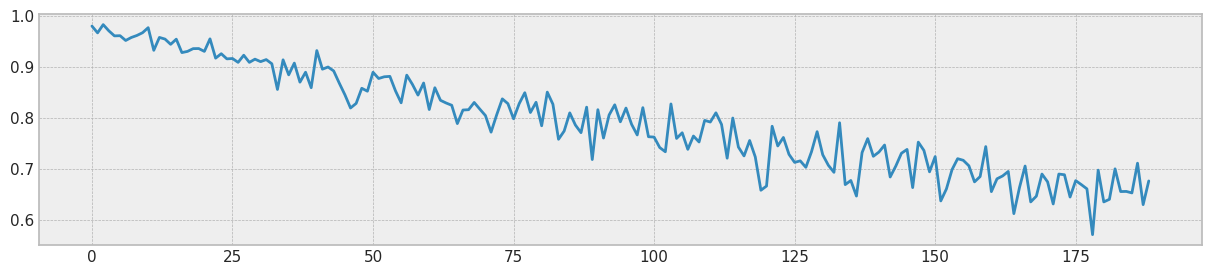

Mean F1 for all data: 0.7931353312919157
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 0.062765] [G loss: 0.564345]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 0.087505] [G loss: 0.476899]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 0.110192] [G loss: 0.390871]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 0.135859] [G loss: 0.304074]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 0.138466] [G loss: 0.239675]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 0.133491] [G loss: 0.192709]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 0.127126] [G loss: 0.158565]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 0.120054] [G loss: 0.133827]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 0.112647] [G loss: 0.115865]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 0.105382] [G loss: 0.102394]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 0.098626] [G loss: 0.091937]
[Lambda: 0.100000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 323.07it/s]


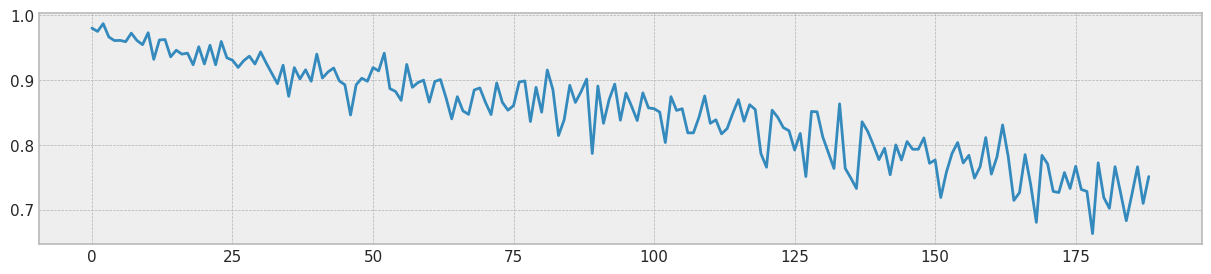

Mean F1 for all data: 0.8484812522725774
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 0.018202] [G loss: 0.574017]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 0.021000] [G loss: 0.489372]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 0.026514] [G loss: 0.408130]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 0.035467] [G loss: 0.325731]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 0.038081] [G loss: 0.260947]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 0.038982] [G loss: 0.212242]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 0.038795] [G loss: 0.176176]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 0.038362] [G loss: 0.149350]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 0.037767] [G loss: 0.129160]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 0.036708] [G loss: 0.113771]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 0.034975] [G loss: 0.102058]
[Lambda: 0.200000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 333.58it/s]


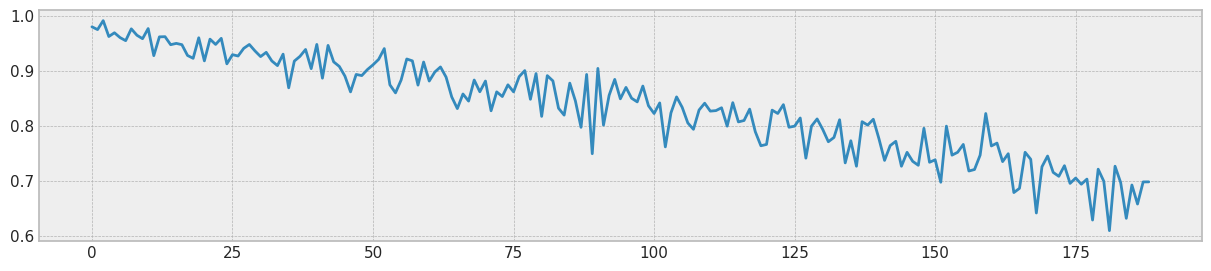

Mean F1 for all data: 0.8351379455571324
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 0.010099] [G loss: 0.577661]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 0.008222] [G loss: 0.494339]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 0.009978] [G loss: 0.415465]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 0.013682] [G loss: 0.335756]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 0.015233] [G loss: 0.271643]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 0.016114] [G loss: 0.222720]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 0.016589] [G loss: 0.185970]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 0.017175] [G loss: 0.158205]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 0.017099] [G loss: 0.137414]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 0.016920] [G loss: 0.121377]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 0.016541] [G loss: 0.108864]
[Lambda: 0.300000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 315.01it/s]


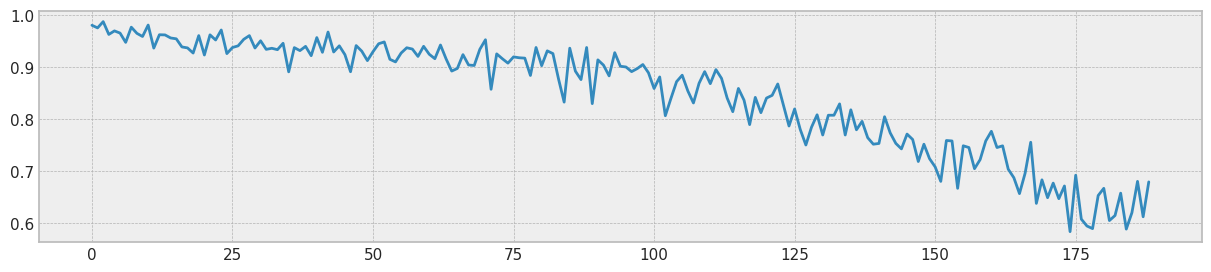

Mean F1 for all data: 0.8456770746742912
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.007592] [G loss: 0.579584]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.004108] [G loss: 0.496975]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 0.004584] [G loss: 0.419558]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 0.006207] [G loss: 0.341603]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 0.007139] [G loss: 0.277899]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.007565] [G loss: 0.229149]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 0.007925] [G loss: 0.192289]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.008199] [G loss: 0.164475]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 0.008367] [G loss: 0.143211]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 0.008444] [G loss: 0.126796]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 0.008384] [G loss: 0.113880]
[Lambda: 0.400000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 327.42it/s]


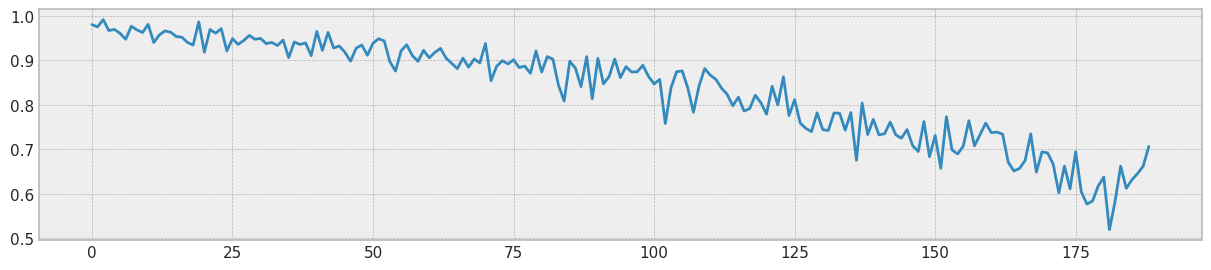

Mean F1 for all data: 0.8330606135081061
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.006626] [G loss: 0.580773]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.002435] [G loss: 0.498619]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 0.002394] [G loss: 0.422161]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 0.003057] [G loss: 0.345436]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 0.003514] [G loss: 0.282040]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 0.003753] [G loss: 0.233337]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 0.003954] [G loss: 0.196520]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 0.004069] [G loss: 0.168695]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 0.004191] [G loss: 0.147411]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 0.004232] [G loss: 0.130925]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 0.004251] [G loss: 0.117797]
[Lambda: 0.500000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 332.94it/s]


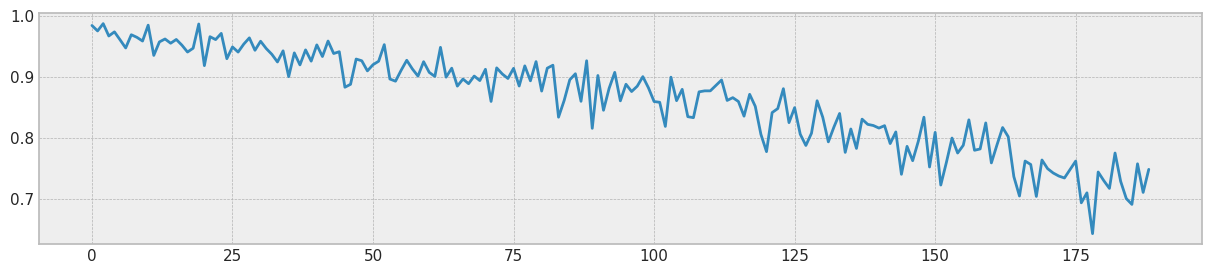

Mean F1 for all data: 0.8628090756964355
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 0.006219] [G loss: 0.581575]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 0.001660] [G loss: 0.499732]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 0.001369] [G loss: 0.423980]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 0.001580] [G loss: 0.348165]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 0.001759] [G loss: 0.285091]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 0.001862] [G loss: 0.236516]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 0.001932] [G loss: 0.199770]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 0.001988] [G loss: 0.171899]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 0.002051] [G loss: 0.150628]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 0.002102] [G loss: 0.134084]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 0.002117] [G loss: 0.120884]
[Lambda: 0.600000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 329.21it/s]


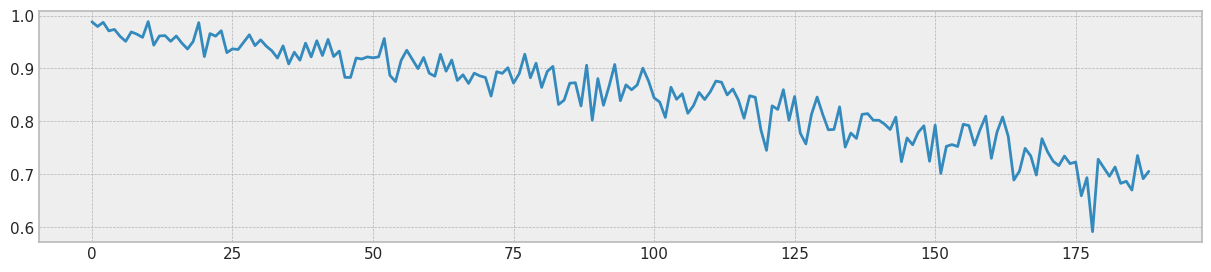

Mean F1 for all data: 0.8498894276516475
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 0.006048] [G loss: 0.582157]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 0.001281] [G loss: 0.500542]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 0.000863] [G loss: 0.425318]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 0.000846] [G loss: 0.350203]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 0.000866] [G loss: 0.287417]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 0.000885] [G loss: 0.238967]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 0.000892] [G loss: 0.202304]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 0.000912] [G loss: 0.174465]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 0.000937] [G loss: 0.153210]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 0.000959] [G loss: 0.136689]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 0.000973] [G loss: 0.123439]
[Lambda: 0.700000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 331.26it/s]


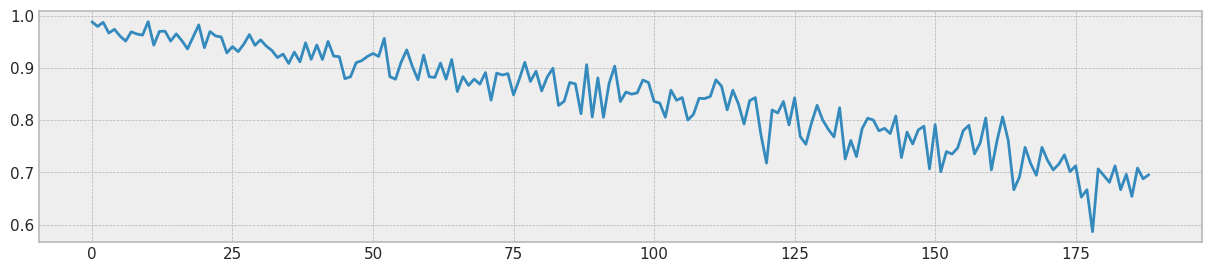

Mean F1 for all data: 0.8422501702617666
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 0.005986] [G loss: 0.582593]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 0.001093] [G loss: 0.501144]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 0.000617] [G loss: 0.426340]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 0.000484] [G loss: 0.351812]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 0.000427] [G loss: 0.289231]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 0.000399] [G loss: 0.240900]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 0.000381] [G loss: 0.204261]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 0.000377] [G loss: 0.176464]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 0.000380] [G loss: 0.155254]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 0.000385] [G loss: 0.138755]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 0.000391] [G loss: 0.125488]
[Lambda: 0.800000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 326.78it/s]


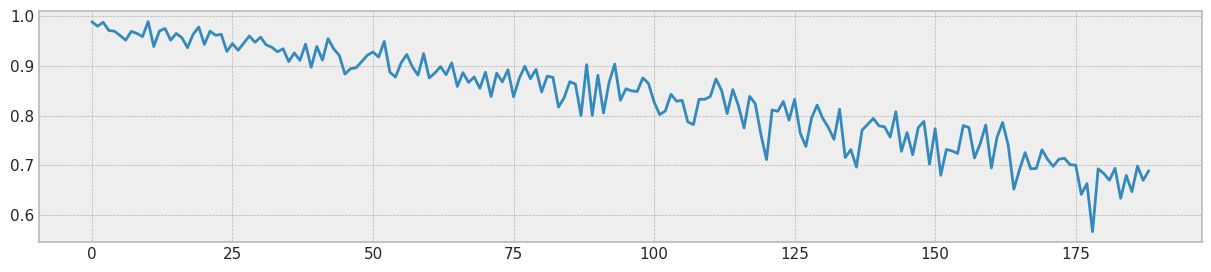

Mean F1 for all data: 0.8357438022484158
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 0.005979] [G loss: 0.582937]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 0.001005] [G loss: 0.501618]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 0.000507] [G loss: 0.427163]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 0.000324] [G loss: 0.353137]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 0.000233] [G loss: 0.290702]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 0.000183] [G loss: 0.242478]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 0.000154] [G loss: 0.205861]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 0.000138] [G loss: 0.178126]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 0.000129] [G loss: 0.156984]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 0.000124] [G loss: 0.140550]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 0.000120] [G loss: 0.127322]
[Lambda: 0.900000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 327.16it/s]


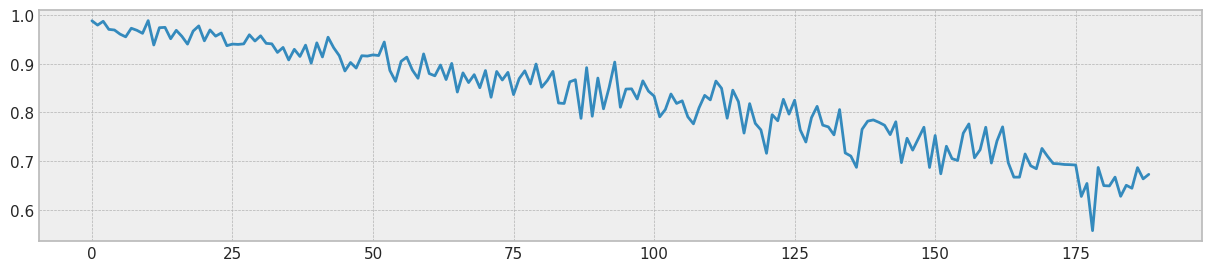

Mean F1 for all data: 0.8290837011230705


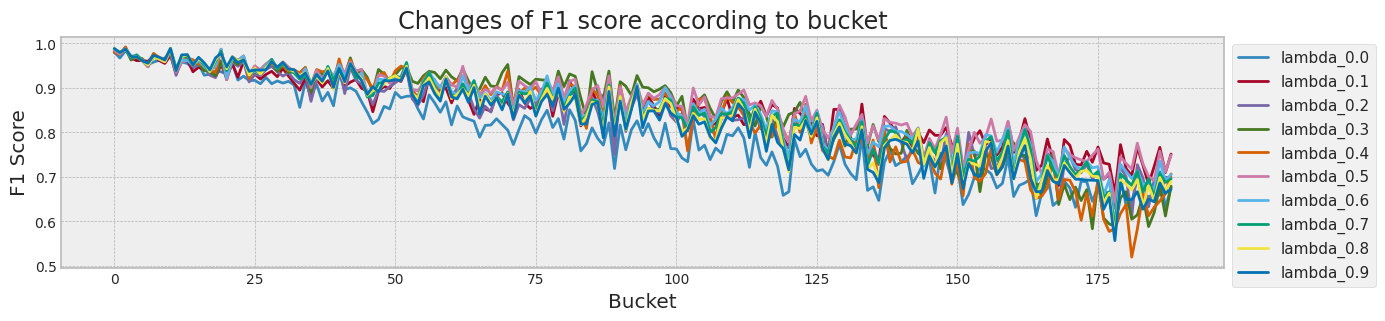

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.002514
1  Case #2 Feature 5  0.875000  0.987952  0.877103  0.752137  0.012903
2  Case #3 Feature 5  0.969697  0.939394  0.731917  0.648148  0.000000
3  Case #3 Feature 4  0.969697  0.864583  0.857218  0.871560  0.000000
4  Case #4 Feature 5  0.973214  0.980237  0.821443  0.672489  0.006732
0                0.0  0.973913  0.980237  0.793135  0.676692  0.302736
1                0.1  0.974138  0.980237  0.848481  0.751131  0.291261
2                0.2  0.969697  0.980237  0.835138  0.698925  0.288488
3                0.3  0.965517  0.980237  0.845677  0.679012  0.273702
4                0.4  0.965517  0.980237  0.833061  0.706587  0.273702
5                0.5  0.961039  0.984127  0.862809  0.748815  0.259096
6                0.6  0.956522  0.988048  0.849889  0.705357  0.256219
7                0.7  0.956522  0.988048  0.842250  0.695279  0.256219
8                0.8  0.964912  0.988048  0.835744  0.689362  0.251604
9                0.9  0.964912  0.988048  0.829084  0.672414  0.251604

In [68]:
#train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.

lambda_f_set2 = [1.2] #[0.391] 

for lambda_f2 in lambda_f_set2:
    
    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:

        f1,mi,last_generator, last_adapter = train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=lambda_f2)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter, X[2000:][['x0','x1','x2','x3','z0','b']], y[2000:])

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3),title='Changes of F1 score according to bucket',ylabel='F1 Score',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    result4_df = pd.DataFrame(result_table2)

pd.concat([pd.DataFrame(result_table3),result4_df])